# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> APCOMP209A Introduction to Data Science:
## Final Group Project: Predicting Ride-Sharing Prices in Boston


**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
**Authors**: Xiaotong (Cindy) Sun, Junzhi (Molly) Han, Hanzhen (Jenny) Zhu, and Xiaoman (Nicole) Xu

<hr style="height:2.4pt">


## Table of Contents

- [Data Cleaning](#data-cleaning)
- [Exploratory Data Analysis (EDA)](#eda)
  - [Outcome Variable Check](#outcome)
  - [Categorical Variables Check](#categorical)
  - [Numerical Variables Check](#numerical)
  - [Correlation Check](#correlation)

- [Feature Engineering](#feature-engineering)
  - [Cyclical Encoding](#cyclical)
  - [Train–Test Split](#split)
  - [Target Encoding](#target-encoding)
  - [One-Hot Encoding](#one-hot)
  - [Design Matrices](#design-matrix)

- [Baseline Model](#baseline)
  - [Baseline Model Results](#baseline-results)

- [Multiple Linear Regression (MLR)](#mlr)
  - [Interaction Terms](#interaction)
  - [LASSO Variable Selection](#lasso)
  - [Train MLR](#train-mlr)
  - [MLR Results](#mlr-results)
  - [MLR Feature Importance](#mlr-importance)

- [Decision Tree Regression](#dt)
  - [Decision Tree Results](#dt-results)
  - [Decision Tree Feature Importance](#dt-importance)

- [Polynomial Regressions](#poly)
  - [Simple Polynomial Regression (Distance-Only Model)](#simple-poly)
  - [Simple Polynomial Regression Results](#simple-poly-results)
  - [Full Polynomial Regression with LASSO-Selected Features](#full-poly)
  - [Full Polynomial Regression Results](#full-poly-results)
  - [Full Polynomial Regression Feature Importance](#full-poly-importance)

- [Model Comparison](#model-comparison)


In [1]:
# ==== Package Check & Auto-Install ==========================================
import importlib
import sys
import subprocess

def install_if_missing(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        importlib.import_module(import_name)
        print(f"✓ {pkg_name} already installed")
    except ImportError:
        print(f"⚠ {pkg_name} not found — installing…")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])
        print(f"✔ Installed {pkg_name} successfully")

required_packages = [
    ("matplotlib", "matplotlib"),
    ("numpy", "numpy"),
    ("pandas", "pandas"),
    ("seaborn", "seaborn"),
    ("statsmodels", "statsmodels"),
    ("scikit-learn", "sklearn"),
    ("category_encoders", "category_encoders")
]

for pkg, import_name in required_packages:
    install_if_missing(pkg, import_name)

# ==== Imports ==============================================================

# hide warnings to keep printout clean
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["PANDAS_IGNORE_BOTTLENECK"] = "1"
import numpy as np
import pandas as pd
import seaborn as sns
import math
import statsmodels.formula.api as smf
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

✓ matplotlib already installed
✓ numpy already installed
✓ pandas already installed
✓ seaborn already installed
✓ statsmodels already installed
✓ scikit-learn already installed
✓ category_encoders already installed


<a id="data-cleaning"></a>
# Data Cleaning

In [2]:
df = pd.read_csv('data/rideshare_kaggle.csv')

# select variables needed for this project
selected_vars = [
    "id", "price", "distance", "cab_type", "name",
    "timestamp", "hour", "day", "source", "destination",
    "temperature", "precipIntensity", "precipProbability", "cloudCover",
    "surge_multiplier"
]

df = df[selected_vars].copy()
df.head()

,id,price,distance,cab_type,name,timestamp,hour,day,source,destination,temperature,precipIntensity,precipProbability,cloudCover,surge_multiplier
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,5.0,0.44,Lyft,Shared,1.544953e+09,9,16,Haymarket Square,North Station,42.34,0.0000,0.0,0.72,1.0
1,4bd23055-6827-41c6-b23b-3c491f24e74d,11.0,0.44,Lyft,Lux,1.543284e+09,2,27,Haymarket Square,North Station,43.58,0.1299,1.0,1.00,1.0
2,981a3613-77af-4620-a42a-0c0866077d1e,7.0,0.44,Lyft,Lyft,1.543367e+09,1,28,Haymarket Square,North Station,38.33,0.0000,0.0,0.03,1.0
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,26.0,0.44,Lyft,Lux Black XL,1.543554e+09,4,30,Haymarket Square,North Station,34.38,0.0000,0.0,0.00,1.0
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,9.0,0.44,Lyft,Lyft XL,1.543463e+09,3,29,Haymarket Square,North Station,37.44,0.0000,0.0,0.44,1.0


In [3]:
# rename the original day to day_of_month
df['day_of_month'] = df['day'].astype(int)

# fix timestamp and create proper day variables
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

df["month_name"] = df["datetime"].dt.month_name()  # January, February, ...
df["day_of_week"] = df["datetime"].dt.day_name()  # Monday, Tuesday, ...


# create a new binary indicator for is_weekend
df['is_weekend'] = df['day_of_week'].isin(["Saturday", "Sunday"])

# remove variables not needed
df = df.drop(columns=["day", "timestamp", "datetime"])

df.head()

,id,price,distance,cab_type,name,hour,source,destination,temperature,precipIntensity,precipProbability,cloudCover,surge_multiplier,day_of_month,month_name,day_of_week,is_weekend
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,5.0,0.44,Lyft,Shared,9,Haymarket Square,North Station,42.34,0.0000,0.0,0.72,1.0,16,December,Sunday,True
1,4bd23055-6827-41c6-b23b-3c491f24e74d,11.0,0.44,Lyft,Lux,2,Haymarket Square,North Station,43.58,0.1299,1.0,1.00,1.0,27,November,Tuesday,False
2,981a3613-77af-4620-a42a-0c0866077d1e,7.0,0.44,Lyft,Lyft,1,Haymarket Square,North Station,38.33,0.0000,0.0,0.03,1.0,28,November,Wednesday,False
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,26.0,0.44,Lyft,Lux Black XL,4,Haymarket Square,North Station,34.38,0.0000,0.0,0.00,1.0,30,November,Friday,False
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,9.0,0.44,Lyft,Lyft XL,3,Haymarket Square,North Station,37.44,0.0000,0.0,0.44,1.0,29,November,Thursday,False


In [4]:
# General info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 693071 non-null  object 
 1   price              637976 non-null  float64
 2   distance           693071 non-null  float64
 3   cab_type           693071 non-null  object 
 4   name               693071 non-null  object 
 5   hour               693071 non-null  int64  
 6   source             693071 non-null  object 
 7   destination        693071 non-null  object 
 8   temperature        693071 non-null  float64
 9   precipIntensity    693071 non-null  float64
 10  precipProbability  693071 non-null  float64
 11  cloudCover         693071 non-null  float64
 12  surge_multiplier   693071 non-null  float64
 13  day_of_month       693071 non-null  int64  
 14  month_name         693071 non-null  object 
 15  day_of_week        693071 non-null  object 
 16  is

In [5]:
# Shape
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 693071, Columns: 17


In [6]:
# Check for duplicates
print(f"Duplicated rows: {df.duplicated().sum()}")

Duplicated rows: 0


In [7]:
# number of missing values
df.isna().sum().sort_values(ascending=False).head()

price              55095
id                     0
precipIntensity        0
day_of_week            0
month_name             0
dtype: int64

<a id="eda"></a>
# Exploratory Data Analysis (EDA)

<a id="outcome"></a>
## Outcome Variable Check

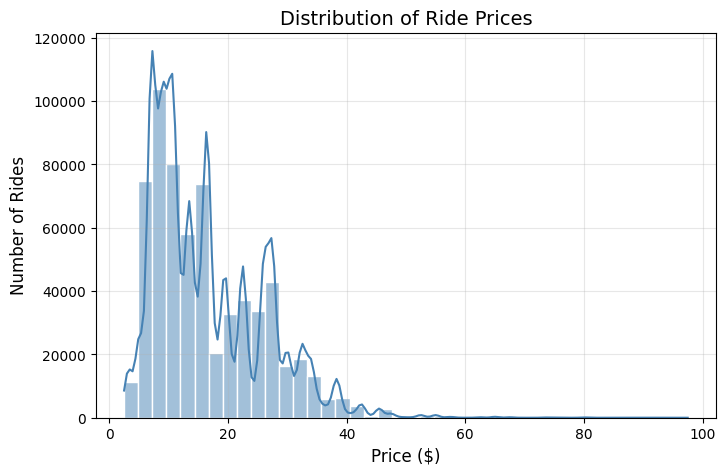

In [8]:
# distribution of price (original), with na values removed
prices = df['price'].dropna()

plt.figure(figsize=(8,5))
sns.histplot(prices, bins=40, kde=True, color='steelblue', edgecolor='white')

plt.title('Distribution of Ride Prices', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Number of Rides', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

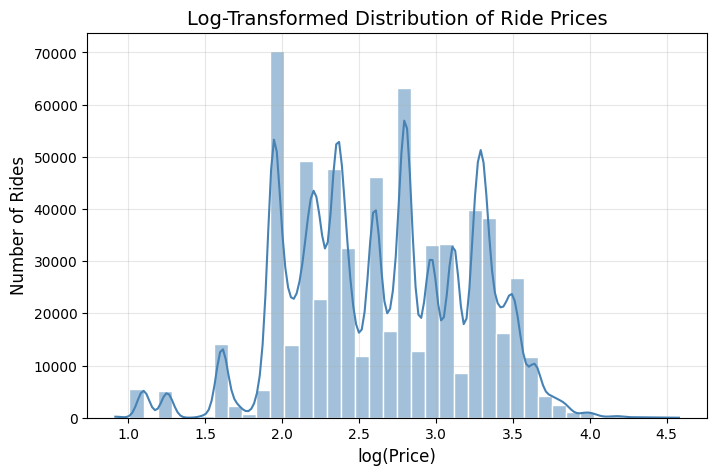

In [9]:
# distribution of price (transformed), with na values removed
# Use np.log1p() to handle any zero or near-zero prices safely
prices = np.log(df['price'].dropna())

plt.figure(figsize=(8,5))
sns.histplot(prices, bins=40, kde=True, color='steelblue', edgecolor='white')

plt.title('Log-Transformed Distribution of Ride Prices', fontsize=14)
plt.xlabel('log(Price)', fontsize=12)
plt.ylabel('Number of Rides', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

<a id="categorical"></a>
## Categorical Variables Check

In [10]:
categorical_var = [
    "cab_type",
    "name",
    "source",
    "destination",
    "month_name",
    "day_of_week",
    "is_weekend",
    "day_of_month",
    "hour"
]

In [11]:
cat_summary = df[categorical_var].describe()

print("\n===== Categorical Variables Summary =====")
display(cat_summary)


===== Categorical Variables Summary =====


,day_of_month,hour
count,693071.000000,693071.000000
mean,17.794365,11.619137
std,9.982286,6.948114
min,1.000000,0.000000
25%,13.000000,6.000000
50%,17.000000,12.000000
75%,28.000000,18.000000
max,30.000000,23.000000


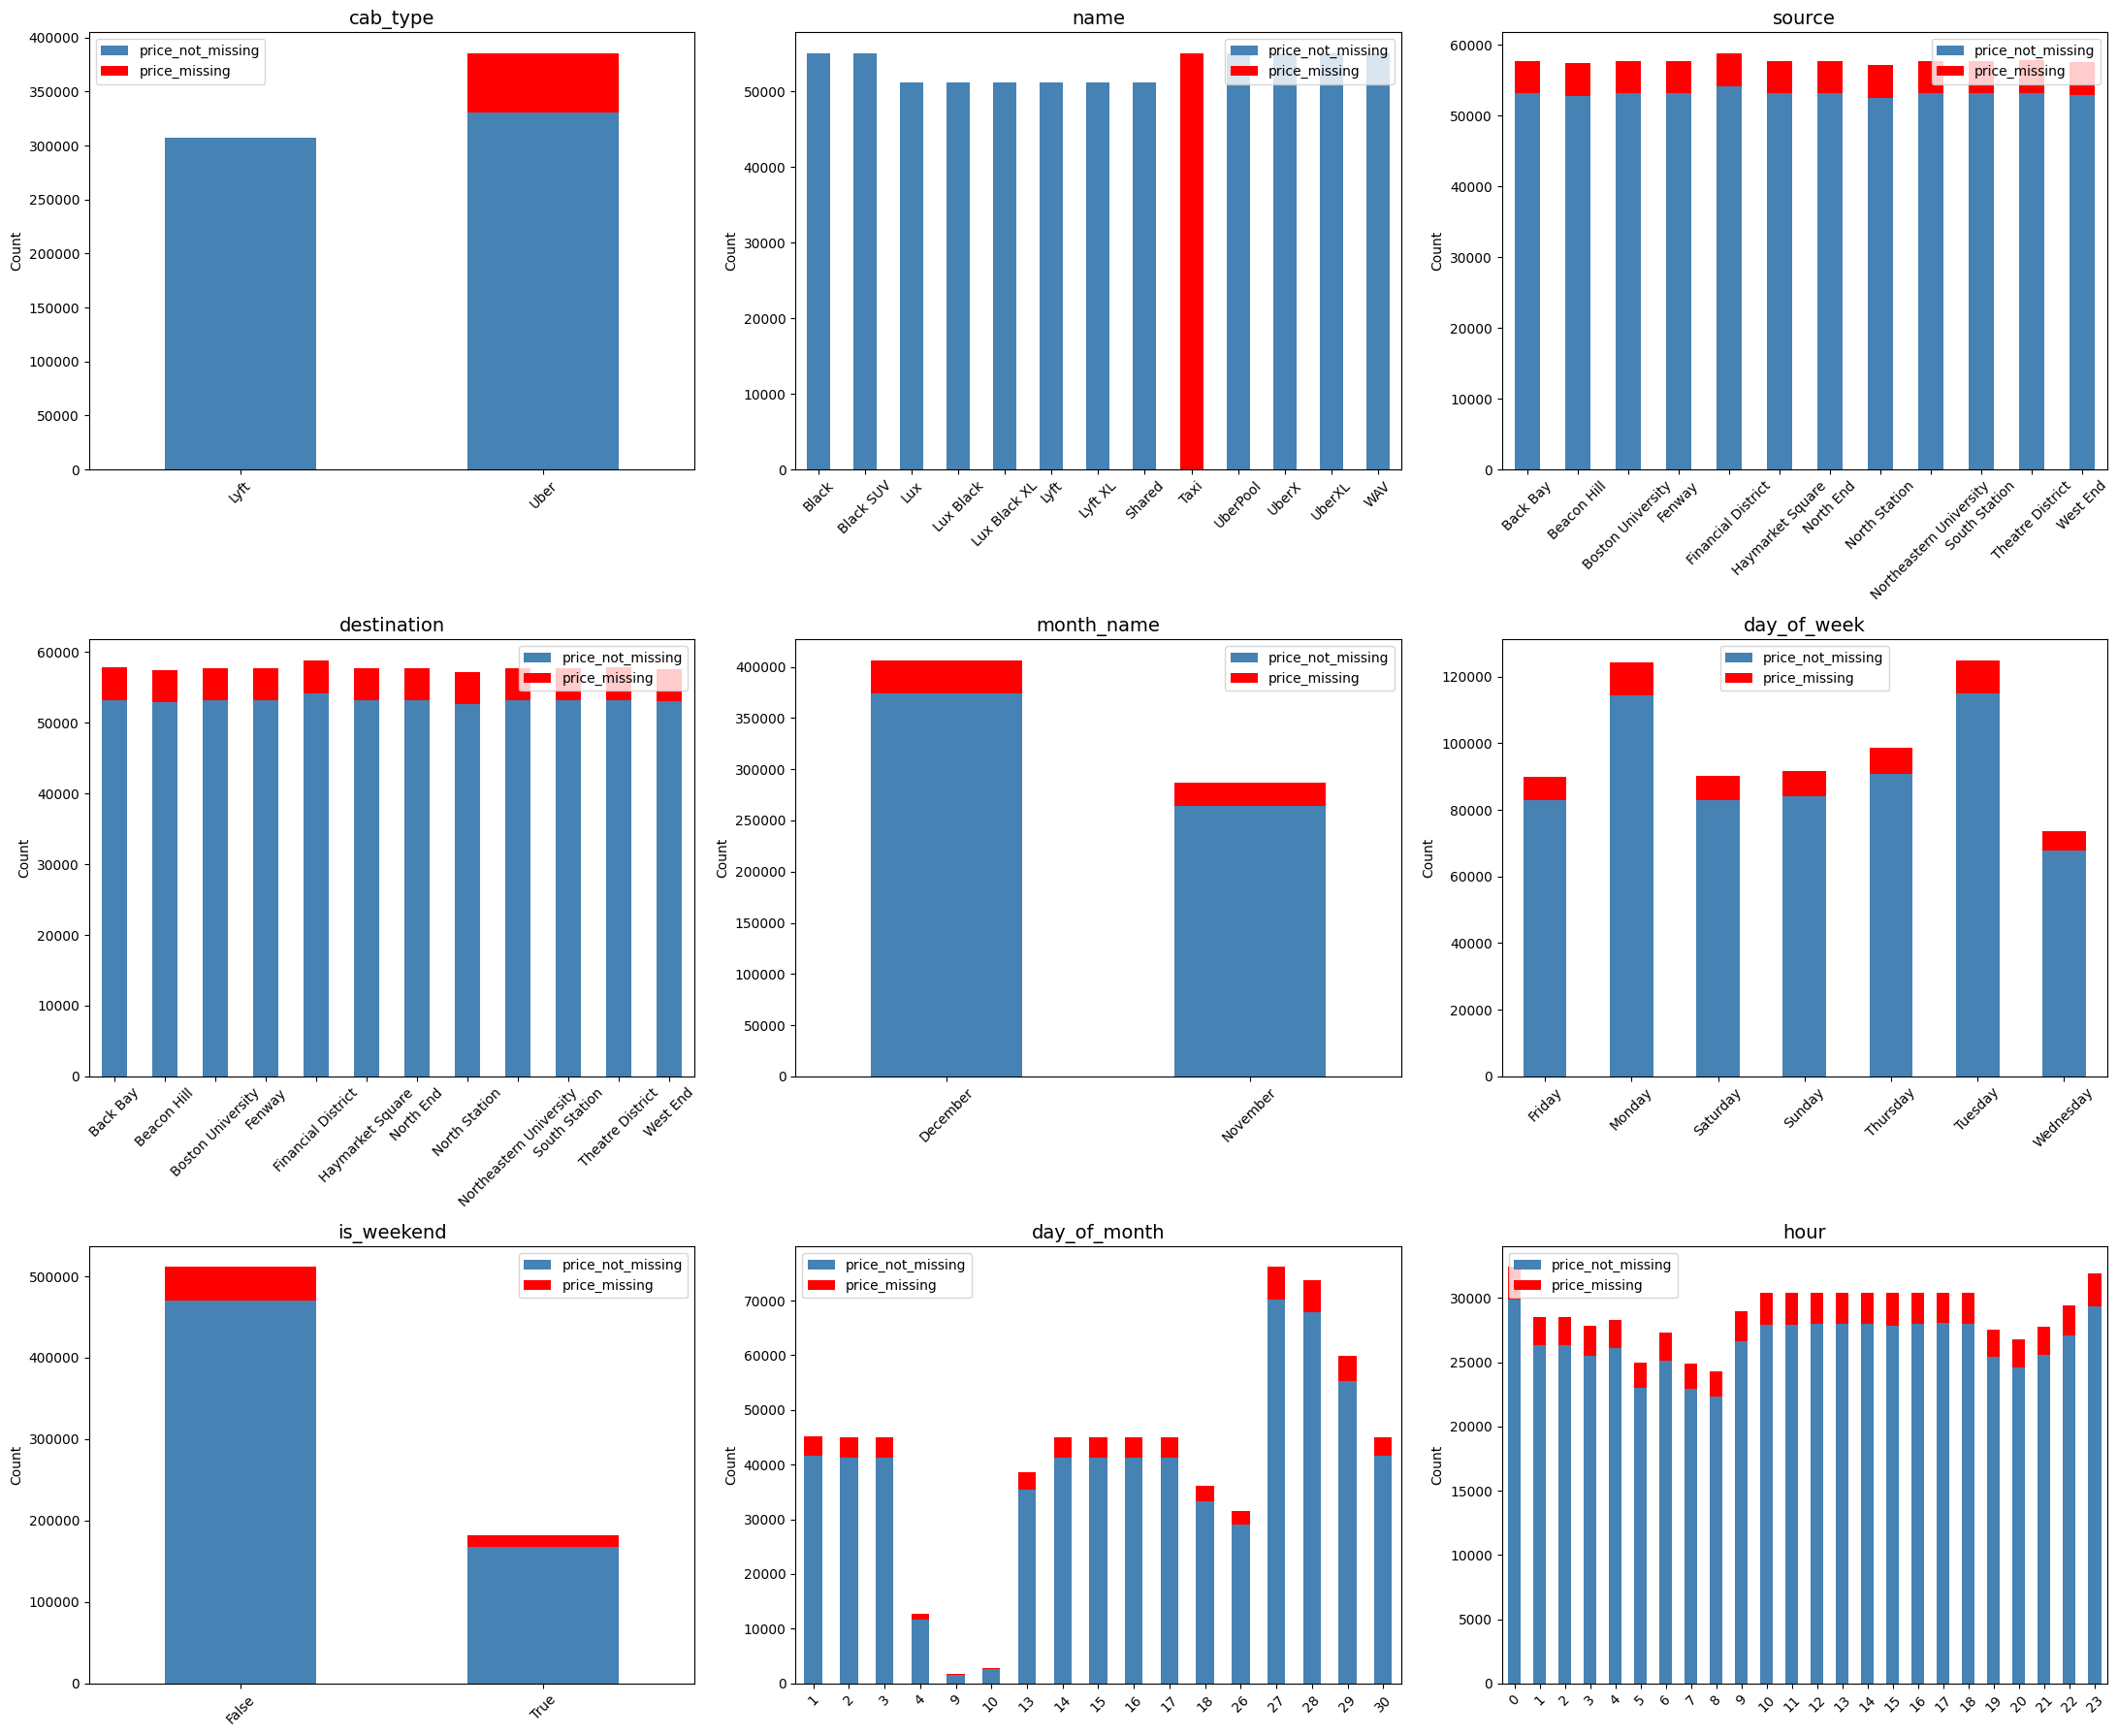

In [12]:
n = len(categorical_var)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(22, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(categorical_var):
    # group category by price missing / not missing
    counts = df.groupby([col, df['price'].isna()]).size().unstack(fill_value=0)
    # rename columns for clarity
    counts.columns = ['price_not_missing', 'price_missing']
    
    # stacked bar plot
    counts[['price_not_missing', 'price_missing']].plot(
        kind='bar',
        stacked=True,
        ax=axes[i],
        color=['steelblue', 'red']  # normal + missing price in red
    )
    
    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', labelrotation=45)

# hide unused subplots if number of vars % 3 != 0
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

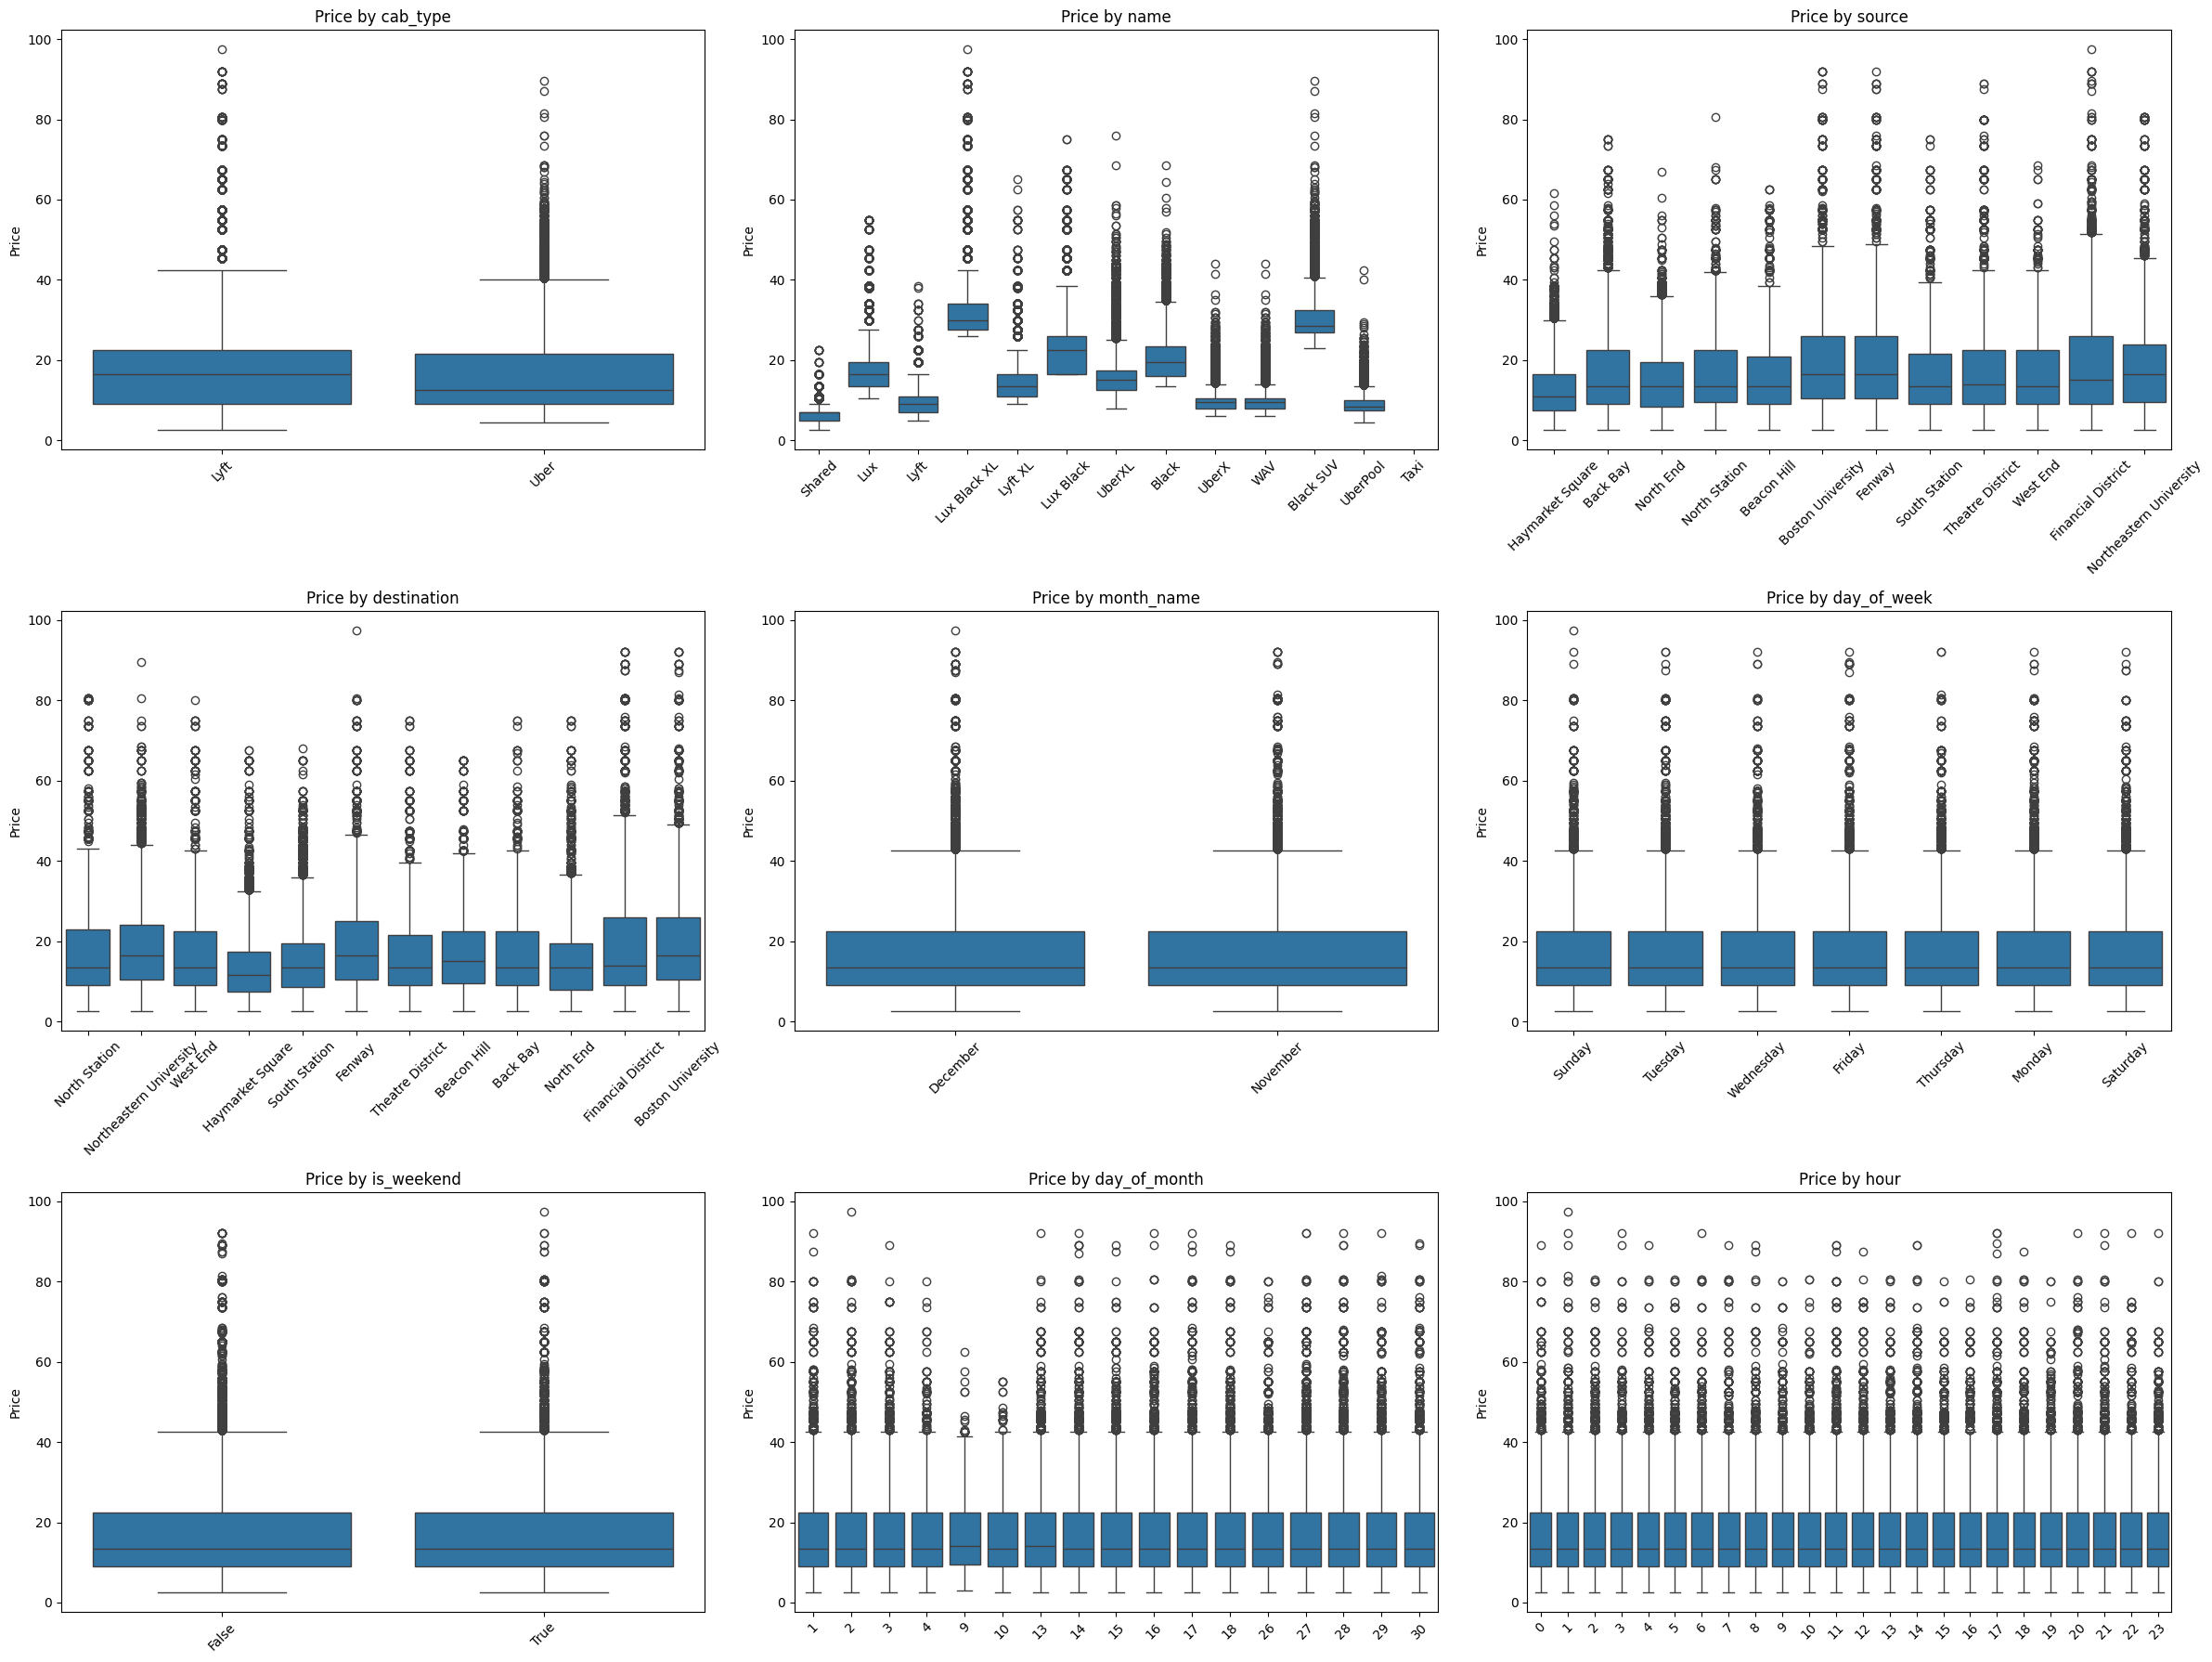

In [13]:
n = len(categorical_var)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(24, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(categorical_var):
    sns.boxplot(data=df, x=col, y="price", ax=axes[i])
    axes[i].set_title(f"Price by {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Price")
    axes[i].tick_params(axis="x", rotation=45)

# hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Insights**:

The categorical predictors in our dataset reveal consistent pricing patterns overall, with a few variables displaying meaningful differences.

- `name` shows the strongest variation in fares, followed by `cab_type`, with premium services (e.g., Lyft Lux Black XL, Uber Black SUV) consistently priced higher than other ride options.
- `source` and `destination` meaningfully affect price — major transit hubs and airports are associated with higher median fares, likely due to longer trip distances and elevated demand.
- Temporal categories — `month_name`, `day_of_week`, `is_weekend`, `day_of_month`, and `hour` — exhibit relatively modest variation in fare distributions, implying these variables play a secondary role compared to service level and geographic context.

Overall, the strongest price signals arise from `cab_type`, `name`, `source`, and `destination`, whereas time-based and weather-based predictors contribute weaker direct effects.

These categorical findings reinforce that ride type and geographic endpoints are the primary drivers of price differences in the dataset.


<a id="numerical"></a>
## Numerical Variables Check

In [14]:
numerical_var = [
    "distance",
    "temperature",
    "precipIntensity",
    "precipProbability",
    "cloudCover",
    "surge_multiplier"
]

In [15]:
num_summary = df[numerical_var].describe().round(2)

print("\n===== Numerical Variables Summary =====")
display(num_summary)


===== Numerical Variables Summary =====


,distance,temperature,precipIntensity,precipProbability,cloudCover,surge_multiplier
count,693071.00,693071.00,693071.00,693071.00,693071.00,693071.00
mean,2.19,39.58,0.01,0.15,0.69,1.01
std,1.14,6.73,0.03,0.33,0.36,0.09
min,0.02,18.91,0.00,0.00,0.00,1.00
25%,1.28,36.45,0.00,0.00,0.37,1.00
50%,2.16,40.49,0.00,0.00,0.82,1.00
75%,2.92,43.58,0.00,0.00,1.00,1.00
max,7.86,57.22,0.14,1.00,1.00,3.00


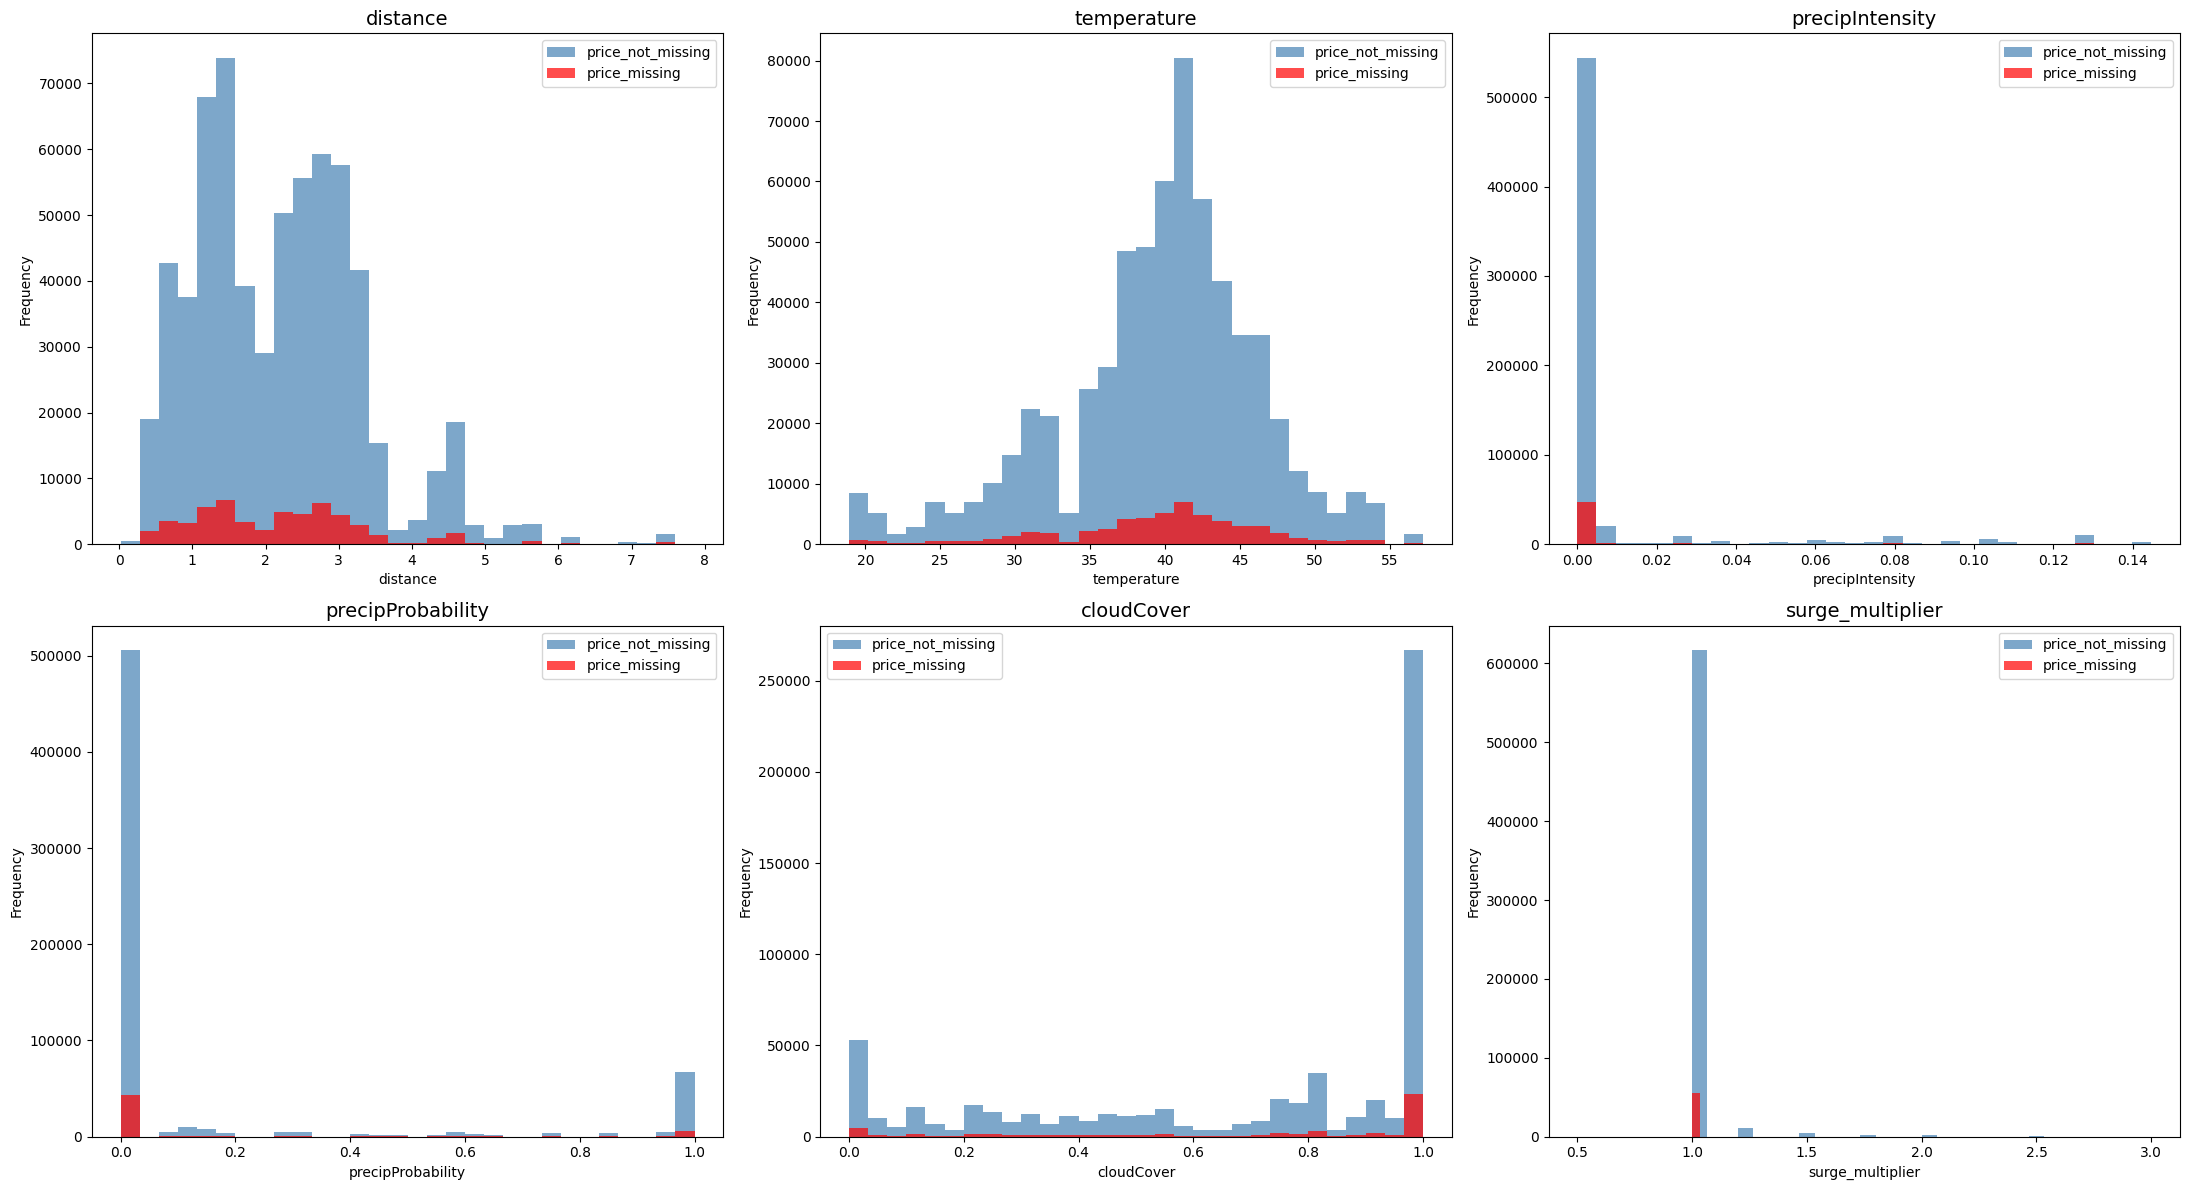

In [16]:
n = len(numerical_var)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(22, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(numerical_var):
    # valid price values
    df[df["price"].notna()][col].plot(
        kind='hist',
        bins=30,
        alpha=0.7,
        color='steelblue',
        ax=axes[i],
        label="price_not_missing"
    )

    # missing price values
    df[df["price"].isna()][col].plot(
        kind='hist',
        bins=30,
        alpha=0.7,
        color='red',
        ax=axes[i],
        label="price_missing"
    )

    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

# hide unused subplots (if number of vars not divisible by 3)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

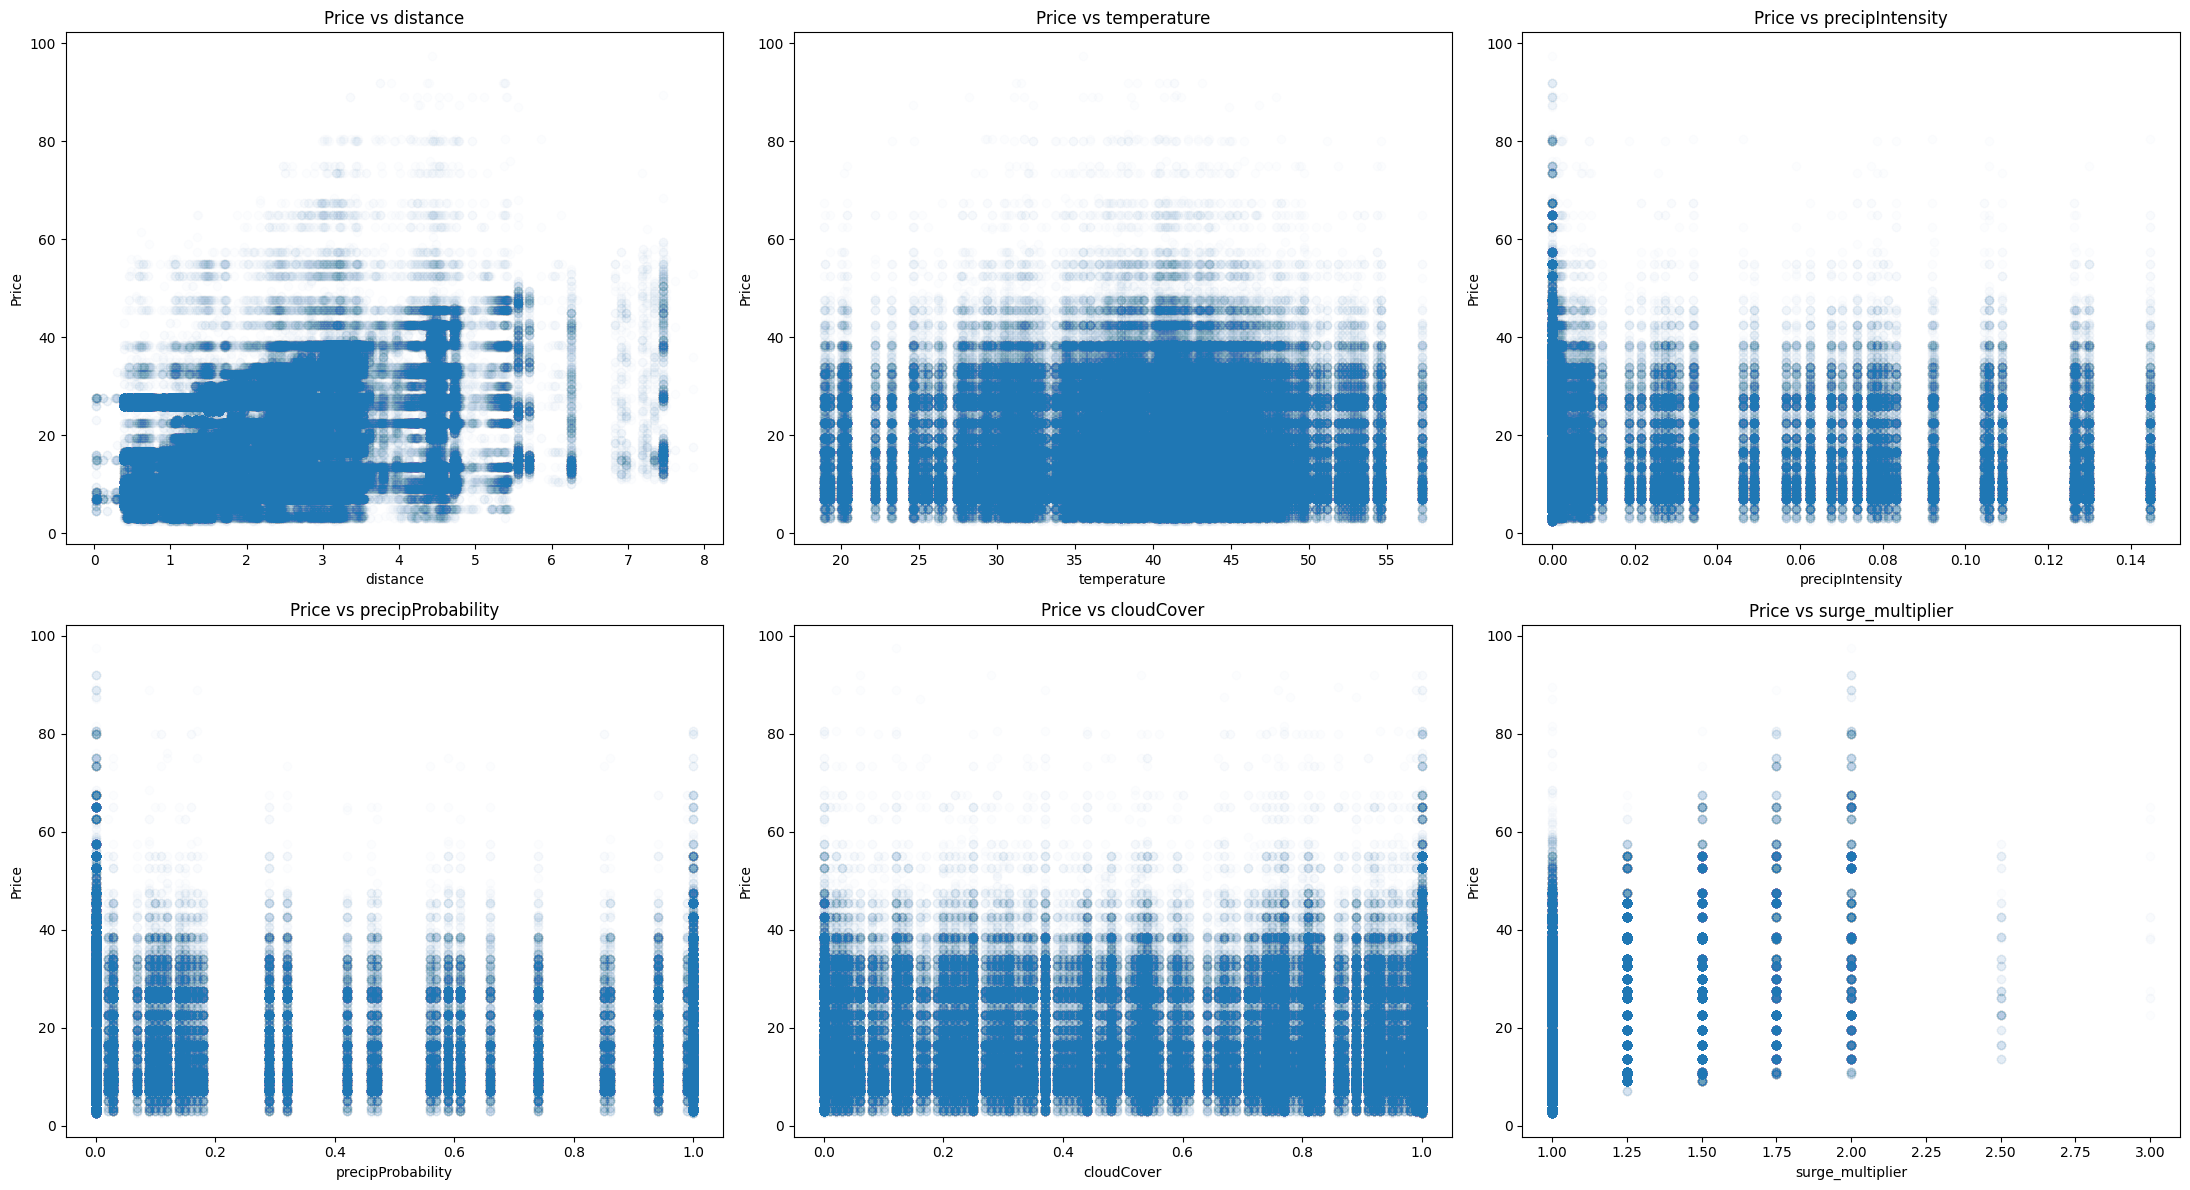

In [17]:
n = len(numerical_var)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(22, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(numerical_var):
    axes[i].scatter(df[col], df["price"], alpha=0.01)
    axes[i].set_title(f"Price vs {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Price")

# hide unused subplots if not multiple of 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [18]:
# Outlier detection
outlier_summary = {}

for col in numerical_var:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary[col] = outliers

pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])

,Outlier Count
distance,8662
temperature,36659
precipIntensity,150828
precipProbability,150828
cloudCover,0
surge_multiplier,20975


**Insights**:

The numerical predictors in our dataset exhibit a wide range of distributional behaviors.

- `distance` has a clear but noisy positive relationship with price.
- `temperature` is moderately distributed, with no visible upward or downward pattern.
- Weather variables, especially `precipIntensity` and `precipProbability`, are extremely right-skewed, with over 150,000 outliers each, reflecting the rarity of heavy precipitation events.
- `cloudCover` is left skewed. Its relationship with price is very weak and effectively flat.
- `surge_multiplier` is highly concentrated at 1.0, indicating that the vast majority of rides occur without surge pricing.

Scatterplots further confirm that `distance` is the only predictor showing a visible positive relationship with `price`. Other numerical variables exhibit weak or no linear associations.

<a id="correlation"></a>
## Correlation Check

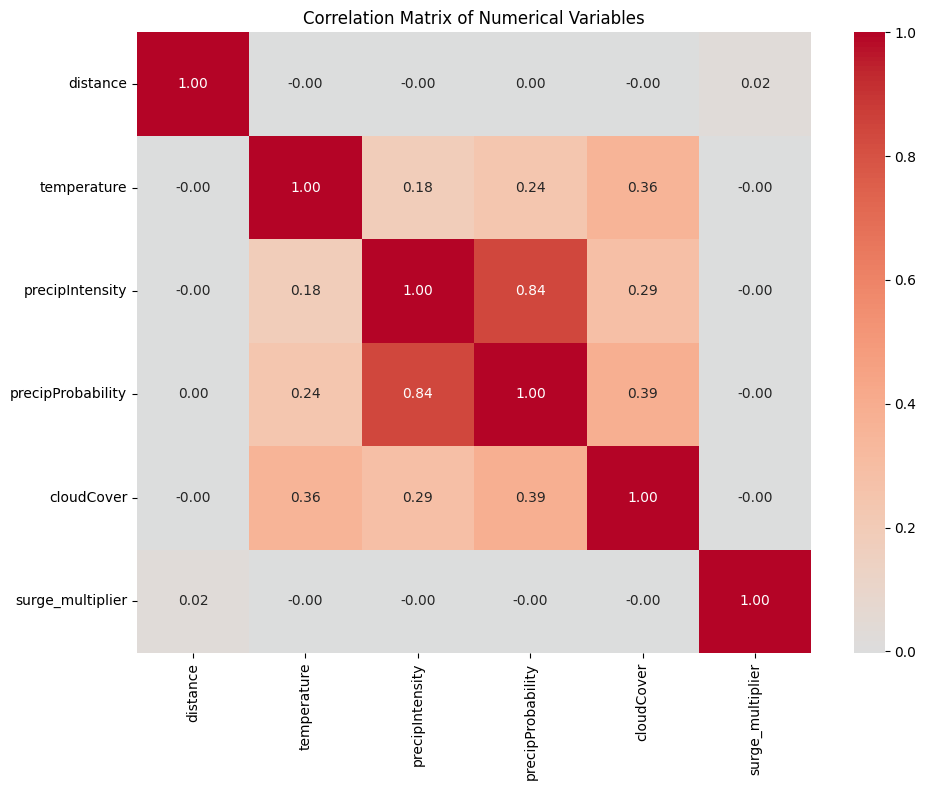

Correlation Matrix:
                   distance  temperature  precipIntensity  precipProbability  \
distance           1.000000    -0.002884        -0.000256           0.000371   
temperature       -0.002884     1.000000         0.182724           0.239165   
precipIntensity   -0.000256     0.182724         1.000000           0.838470   
precipProbability  0.000371     0.239165         0.838470           1.000000   
cloudCover        -0.000905     0.355156         0.288960           0.387114   
surge_multiplier   0.024769    -0.001572        -0.001530          -0.002769   

                   cloudCover  surge_multiplier  
distance            -0.000905          0.024769  
temperature          0.355156         -0.001572  
precipIntensity      0.288960         -0.001530  
precipProbability    0.387114         -0.002769  
cloudCover           1.000000         -0.002103  
surge_multiplier    -0.002103          1.000000  


In [20]:
corr_matrix = df[numerical_var].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(corr_matrix)

**Insights**:

- `precipIntensity` and `precipProbability` are highly correlated (r = 0.84). This is reasonable because higher rainfall intensity typically occurs when the probability of rain is also high—both variables capture related aspects of precipitation events.

- `precipIntensity` and `cloudCover` show slightly positive correlation (r = 0.39). This is reasonable because cloud cover influences precipitation.

- `temperature` and `cloudCover` show slightly positive correlation (r = 0.36). This is reasonable because cloud cover influences temperature patterns—clouds trap heat at night and reduce warming during the day—creating a natural meteorological relationship.  

- Most remaining variables show weak correlations ($|r| < 0.4$), indicating minimal correlation concerns among the numerical predictors.

<a id="feature-engineering"></a>
# Feature Engineering

**Encoding Strategy:** We encoded our categorical variables using 3 different encoding strategies: cyclincal, target, and one-hot encodings. Cyclical encoding for hour and day_of_month was applied prior to the train–validation–test split, since sine–cosine transformations represent a purely deterministic mathematical mapping that does not depend on the target variable and therefore cannot introduce information leakage. After this transformation, the dataset was split into training, validation, and test sets to establish strict out-of-sample evaluation. All one-hot encoding and target encoding steps were then performed after the split and fit exclusively on the training set. One-hot encoding is applied post-split to ensure dimensional consistency across datasets and to prevent unseen category expansion in validation and test sets. Most critically, target encoding of high-cardinality categorical variables (source and destination) is performed only after splitting because it directly uses the target variable (log(price)) to compute category-level statistics; performing this step prior to splitting would introduce data leakage and inflate model performance. This ordered encoding pipeline ensures that all models are trained and evaluated under strictly leakage-free conditions.

In [21]:
# remove missing values 
df_clean = df.dropna()

<a id="cyclical"></a>
## Cyclical Encoding

We applied sine–cosine (cyclical) encoding to hour and day_of_month to preserve their inherent periodic structure, ensuring that temporally adjacent values (e.g., hour 23 and hour 0) are represented as close in feature space rather than artificially distant. Because the dataset contains only November (30 days) and December (31 days), we normalize day_of_month by 30 as a stable approximation for cyclical encoding with negligible phase distortion on December 31.

Note: In EDA, we included hour and day_of_month in the categorical variable list because they represent discrete temporal states rather than continuous magnitudes, and treating them as categories avoids imposing a false linear ordering during exploratory visualization. However, after cyclical encoding, hour and day_of_month are no longer categorical; they are transformed into continuous numerical features that explicitly encode periodic structure, making them suitable for regression and tree-based modeling.

In [22]:
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

df_clean['day_sin'] = np.sin(2 * np.pi * df_clean['day_of_month'] / 30)
df_clean['day_cos'] = np.cos(2 * np.pi * df_clean['day_of_month'] / 30)

<a id="split"></a>
## Train–Test Split

In [23]:
feature_cols = [
    # numerical features
    'distance', 'surge_multiplier', 'temperature', 'precipIntensity', 
    'precipProbability', 'cloudCover',
    
    # cyclical features
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    
    # binary
    'is_weekend',
    
    # categorical
    'month_name', 'source', 'destination', 'name', 'cab_type', 'day_of_week'
]

# feature matrix and target variable (used for both MLR and Decision Tree)
X_features = df_clean[feature_cols].copy()
y_target = np.log(df_clean['price']).copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_features, y_target, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

# reset indices
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"  Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df_clean)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(df_clean)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df_clean)*100:.1f}%)")

  Training set: 382,785 samples (60.0%)
  Validation set: 127,595 samples (20.0%)
  Test set: 127,596 samples (20.0%)


<a id="target-encoding"></a>
## Target Encoding

We employ target encoding for the `source` and `destination` variables rather than traditional one-hot encoding. Our dataset contains 12 unique pickup neighborhoods (`source`) and 12 unique dropoff neighborhoods (`destination`); applying one-hot encoding would therefore introduce 24 binary indicator variables. Target encoding instead compresses these 24 dimensions into just 2 continuous numerical features, substantially reducing dimensionality while preserving predictive signal.

Specifically, each neighborhood is replaced by the training-set mean of `log(price)`, with smoothing applied (`smoothing = 1.0`) to stabilize estimates for less frequent categories. The fitted encoder is learned exclusively on the training data and then applied unchanged to the validation and test sets, ensuring strict prevention of information leakage. This allows the encoded values to reflect economically meaningful neighborhood patterns such as expected demand, typical trip lengths, and surge behavior, while remaining fully out-of-sample.

In [24]:
# define columns for target encoding
location_cols = ['source', 'destination']
target_encoder = TargetEncoder(cols=location_cols, smoothing=1.0)

# fit on training data only
target_encoder.fit(X_train[location_cols], y_train)

# transform all sets
X_train_loc_encoded = target_encoder.transform(X_train[location_cols])
X_val_loc_encoded = target_encoder.transform(X_val[location_cols])
X_test_loc_encoded = target_encoder.transform(X_test[location_cols])

# rename columns
X_train_loc_encoded.columns = ['source_encoded', 'destination_encoded']
X_val_loc_encoded.columns = ['source_encoded', 'destination_encoded']
X_test_loc_encoded.columns = ['source_encoded', 'destination_encoded']

In [25]:
# mapping
# source neighborhoods
encoding_map_source = pd.DataFrame({
    'source': X_train['source'].values,
    'source_encoded': X_train_loc_encoded['source_encoded'].values
}).drop_duplicates().sort_values('source_encoded', ascending=False)

print("\nTop 5 most expensive pickup neighborhoods:")
print(encoding_map_source.head())
print("\nTop 5 least expensive pickup neighborhoods:")
print(encoding_map_source.tail())

# destination neighborhoods
encoding_map_dest = pd.DataFrame({
    'destination': X_train['destination'].values,
    'destination_encoded': X_train_loc_encoded['destination_encoded'].values
}).drop_duplicates().sort_values('destination_encoded', ascending=False)

print("\nTop 5 most expensive dropoff neighborhoods:")
print(encoding_map_dest.head())
print("\nTop 5 least expensive dropoff neighborhoods:")
print(encoding_map_dest.tail())


Top 5 most expensive pickup neighborhoods:
                     source  source_encoded
2         Boston University        2.781737
19                   Fenway        2.762028
9   Northeastern University        2.734369
7        Financial District        2.703400
1          Theatre District        2.659597

Top 5 least expensive pickup neighborhoods:
              source  source_encoded
10          Back Bay        2.624302
13       Beacon Hill        2.622324
4      South Station        2.607104
33         North End        2.575637
25  Haymarket Square        2.457238

Top 5 most expensive dropoff neighborhoods:
                destination  destination_encoded
8         Boston University             2.793605
0                    Fenway             2.749527
1   Northeastern University             2.737349
4        Financial District             2.701635
25            North Station             2.657249

Top 5 least expensive dropoff neighborhoods:
         destination  destination_encode

<a id="one-hot"></a>
## One-Hot Encoding

We apply one-hot encoding to the categorical variables `name`, `cab_type`, `month_name`, and `day_of_week` to convert them into a numerical format suitable for regression-based models. Encoding is performed **after the train–validation–test split** to ensure that all transformations are learned strictly from the training data and to prevent information leakage. For each split, dummy variables are created using `pd.get_dummies()` with `drop_first = True` to avoid perfect multicollinearity under the dummy variable trap. 

Because the validation and test sets may not contain all category levels observed in `X_train`, we explicitly align their feature spaces to the training set by adding any missing dummy columns with zero values and then reordering columns to match the training design matrix (`X_train_categorical`) exactly. This procedure guarantees full dimensional consistency across datasets and ensures that all downstream models receive inputs with identical feature structure.


In [26]:
categorical_cols = ['name', 'cab_type', 'month_name', 'day_of_week'] 

# create dummy variables
X_train_categorical = pd.get_dummies(X_train[categorical_cols], drop_first=True, dtype=int)
X_val_categorical = pd.get_dummies(X_val[categorical_cols], drop_first=True, dtype=int)
X_test_categorical = pd.get_dummies(X_test[categorical_cols], drop_first=True, dtype=int)

all_categorical_cols = X_train_categorical.columns

# add missing columns 
for col in all_categorical_cols:
    if col not in X_val_categorical.columns:
        X_val_categorical[col] = 0
    if col not in X_test_categorical.columns:
        X_test_categorical[col] = 0

# reorder columns
X_val_categorical = X_val_categorical[all_categorical_cols]
X_test_categorical = X_test_categorical[all_categorical_cols]

<a id="design-matrix"></a>
## Design Matrices

In [27]:
numerical_cols = [
    'distance', 'surge_multiplier', 'temperature', 'precipIntensity',
    'precipProbability', 'cloudCover',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
]

# combine everything
X_train_combined = pd.concat([
    X_train[numerical_cols].reset_index(drop=True),
    X_train_loc_encoded.reset_index(drop=True),
    X_train_categorical.reset_index(drop=True)
], axis=1)

X_val_combined = pd.concat([
    X_val[numerical_cols].reset_index(drop=True),
    X_val_loc_encoded.reset_index(drop=True),
    X_val_categorical.reset_index(drop=True)
], axis=1)

X_test_combined = pd.concat([
    X_test[numerical_cols].reset_index(drop=True),
    X_test_loc_encoded.reset_index(drop=True),
    X_test_categorical.reset_index(drop=True)
], axis=1)

print(f"  Total features: {X_train_combined.shape[1]}")
print(f"    - Numerical features: {len(numerical_cols)}")
print(f"    - Target-encoded locations: {X_train_loc_encoded.shape[1]}")
print(f"    - One-hot encoded categoricals: {X_train_categorical.shape[1]}")

  Total features: 31
    - Numerical features: 10
    - Target-encoded locations: 2
    - One-hot encoded categoricals: 19


<a id="baseline"></a>
# Baseline Model: log(price) ~ distance

We establish a baseline benchmark using a simple linear regression of `log(price)` on `distance` only. This model isolates the marginal contribution of trip length to ride pricing by excluding all other temporal, service-type, surge, and location features. The baseline serves as a reference point for evaluating the added predictive value of more advanced models. By fitting this model on the training set and evaluating on the validation and test sets, we obtain a clear lower bound on achievable performance when relying solely on distance as the predictor.

In [28]:
# function to calculate metrics - this will be used in later models as well - for model comparison
def calc_metrics(y_true, y_pred, set_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{set_name}:")
    print(f"  R²:   {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    return {'R²': r2, 'RMSE': rmse}

In [29]:
# log(price) ~ distance

# 1. Subset ONLY the distance predictor
X_train_base = X_train_combined[['distance']]
X_val_base   = X_val_combined[['distance']]
X_test_base  = X_test_combined[['distance']]

y_train_base = y_train.copy()
y_val_base   = y_val.copy()
y_test_base  = y_test.copy()

# 2. Fit baseline model
baseline_model = LinearRegression()
baseline_model.fit(X_train_base, y_train_base)

# 3. Predictions
y_train_pred = baseline_model.predict(X_train_base)
y_val_pred   = baseline_model.predict(X_val_base)
y_test_pred  = baseline_model.predict(X_test_base)

<a id="baseline-results"></a>
## Baseline Model Results

In [30]:
# 4. Print model equation
print("\nBaseline Model: log(price) ~ distance")
print(f"Coefficient (distance): {baseline_model.coef_[0]:.4f}")
print(f"Intercept: {baseline_model.intercept_:.4f}")


Baseline Model: log(price) ~ distance
Coefficient (distance): 0.1685
Intercept: 2.2819


In [31]:
# 5. Metrics
train_metrics_baseline = calc_metrics(y_train_base, y_train_pred, "Training")
val_metrics_baseline   = calc_metrics(y_val_base, y_val_pred, "Validation")
test_metrics_baseline  = calc_metrics(y_test_base, y_test_pred, "Test")

Training:
  R²:   0.1135
  RMSE: 0.5347
Validation:
  R²:   0.1169
  RMSE: 0.5368
Test:
  R²:   0.1149
  RMSE: 0.5352


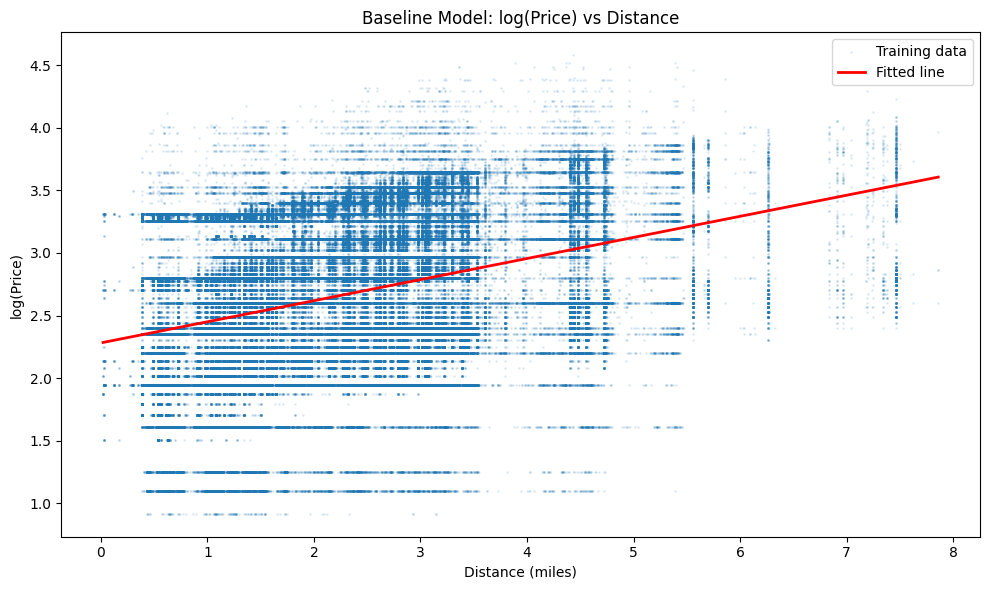

In [32]:
plt.figure(figsize=(10, 6))


plt.scatter(
    X_train['distance'],
    y_train,
    alpha=0.1,
    s=1,
    label="Training data"
)


X_train_sorted = np.sort(X_train[['distance']].values, axis=0)

plt.plot(
    X_train_sorted,
    baseline_model.predict(X_train_sorted),
    color="red",
    linewidth=2,
    label="Fitted line"
)

plt.xlabel("Distance (miles)")
plt.ylabel("log(Price)")
plt.title("Baseline Model: log(Price) vs Distance")
plt.legend()
plt.tight_layout()
plt.show()

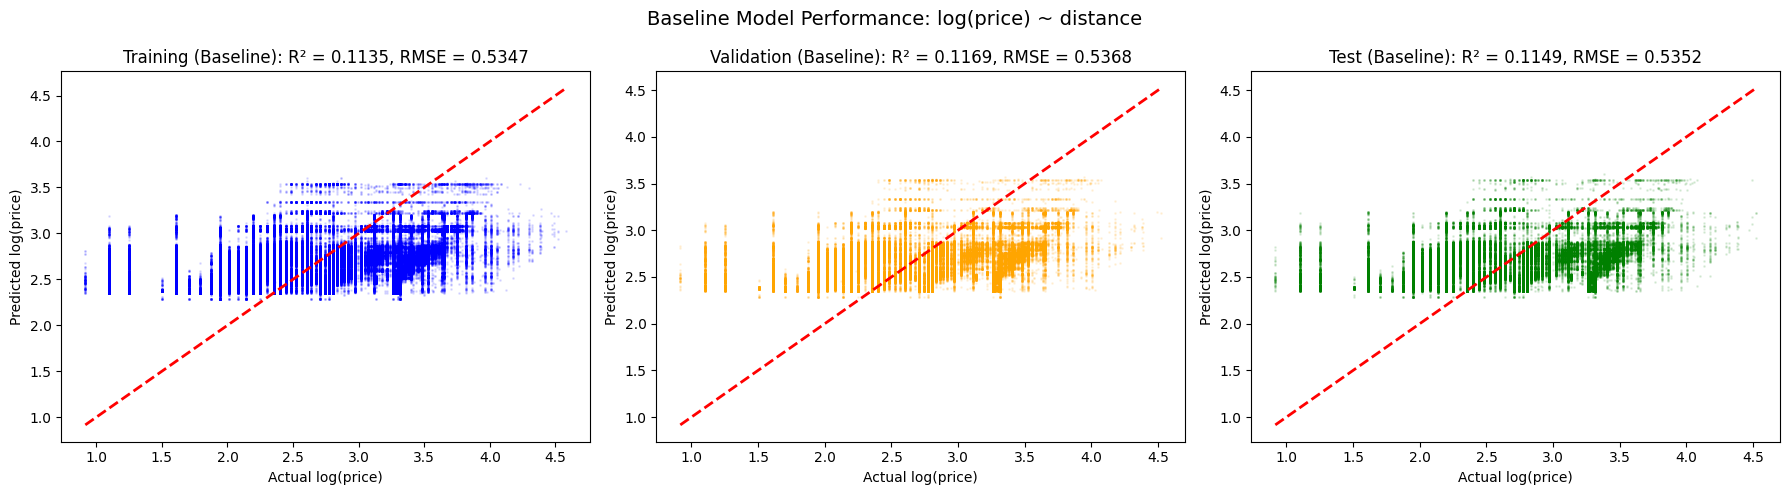

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


# Training (BLUE)
axes[0].scatter(y_train, y_train_pred, alpha=0.1, s=1, color="blue")
axes[0].plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    linestyle="--", linewidth=2, color="red"
)
axes[0].set_title(
    f"Training (Baseline): R² = {train_metrics_baseline['R²']:.4f}, "
    f"RMSE = {train_metrics_baseline['RMSE']:.4f}"
)
axes[0].set_xlabel("Actual log(price)")
axes[0].set_ylabel("Predicted log(price)")


# Validation (ORANGE)
axes[1].scatter(y_val, y_val_pred, alpha=0.1, s=1, color="orange")
axes[1].plot(
    [y_val.min(), y_val.max()],
    [y_val.min(), y_val.max()],
    linestyle="--", linewidth=2, color="red"
)
axes[1].set_title(
    f"Validation (Baseline): R² = {val_metrics_baseline['R²']:.4f}, "
    f"RMSE = {val_metrics_baseline['RMSE']:.4f}"
)
axes[1].set_xlabel("Actual log(price)")
axes[1].set_ylabel("Predicted log(price)")


# Test (GREEN)
axes[2].scatter(y_test, y_test_pred, alpha=0.1, s=1, color="green")
axes[2].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--", linewidth=2, color="red"
)
axes[2].set_title(
    f"Test (Baseline): R² = {test_metrics_baseline['R²']:.4f}, "
    f"RMSE = {test_metrics_baseline['RMSE']:.4f}"
)
axes[2].set_xlabel("Actual log(price)")
axes[2].set_ylabel("Predicted log(price)")


plt.suptitle("Baseline Model Performance: log(price) ~ distance", fontsize=14)
plt.tight_layout()
plt.show()

**Insights:**

The baseline linear regression model using only distance to predict log(price) establishes a simple benchmark for fare prediction. The estimated coefficient for distance is 0.1685, indicating that each additional mile is associated with an approximate 16.9% multiplicative increase in expected price (on the original price scale), holding all else constant. The intercept of 2.2819 represents the expected log-price when distance is zero. The regression plot confirms a clear positive linear relationship between distance and log-price, but also reveals substantial vertical spread at every distance value, indicating large unexplained variability in ride pricing that distance alone cannot capture.

In terms of performance, the model achieves R² values of approximately 0.11 across the training (0.1135), validation (0.1169), and test (0.1149) sets, with corresponding RMSE values around 0.535 on all splits. This consistency across datasets confirms that the model is stable and not overfitting, but the low R² also indicates that distance alone explains only about 11% of the total variation in log-price. The actual-vs-predicted plots further highlight strong underfitting, with predictions compressed into a narrow band relative to the true outcome range.

<a id="mlr"></a>
# Multiple Linear Regression (MLR)

We constructed two interaction terms—`distance × name` and `distance × cab_type`—because exploratory data analysis indicated that these categorical variables explain the greatest variation in ride prices. To control model complexity and address high dimensionality introduced by encoding and interaction terms, we applied LASSO variable selection to penalize redundant predictors and identify the final set of features for the multiple linear regression model.

<a id="interaction"></a>
## Interaction Terms

In [34]:
X_train_final = X_train_combined.copy()
X_val_final = X_val_combined.copy()
X_test_final = X_test_combined.copy()

# distance × name
interaction_count = 0
service_name_cols = [col for col in X_train_categorical.columns if 'name_' in col]

for col in service_name_cols:
    interaction_name = f'distance_x_{col}'
    X_train_final[interaction_name] = X_train_final['distance'] * X_train_final[col]
    X_val_final[interaction_name] = X_val_final['distance'] * X_val_final[col]
    X_test_final[interaction_name] = X_test_final['distance'] * X_test_final[col]
    interaction_count += 1

# distance × cab_type
cab_type_cols = [col for col in X_train_categorical.columns if 'cab_type_' in col]
for col in cab_type_cols:
    interaction_name = f'distance_x_{col}'
    X_train_final[interaction_name] = X_train_final['distance'] * X_train_final[col]
    X_val_final[interaction_name] = X_val_final['distance'] * X_val_final[col]
    X_test_final[interaction_name] = X_test_final['distance'] * X_test_final[col]
    interaction_count += 1

print(f"Created {interaction_count} interaction terms")
print(f"Final feature count: {X_train_final.shape[1]} features")

Created 13 interaction terms
Final feature count: 44 features


<a id="lasso"></a>
## LASSO Variable Selection

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val_final)

feature_names = X_train_final.columns.tolist()

alphas = np.logspace(-4, 3, 100) 

# LassoCV with 5-fold CV
lasso_cv = LassoCV(
    alphas=alphas,
    cv=5,
    max_iter=10000,
    random_state=42,
    n_jobs=-1  
)

lasso_cv.fit(X_train_scaled, y_train)

optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha: {optimal_alpha:.6f}")

Optimal alpha: 0.000100


In [36]:
lasso_model = Lasso(alpha=optimal_alpha, max_iter=10000, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

,alpha,0.0001
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,10000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


In [37]:
lasso_coefs = lasso_model.coef_
feature_names = X_train_final.columns.tolist()

n_nonzero = np.sum(lasso_coefs != 0)
n_zero = np.sum(lasso_coefs == 0)

print(f"\nTotal features: {len(feature_names)}")
print(f"Non-zero coefficients: {n_nonzero}")
print(f"Zero coefficients (eliminated): {n_zero}")


Total features: 44
Non-zero coefficients: 33
Zero coefficients (eliminated): 11


In [38]:
# eliminated features
eliminated_features = [feature_names[i] for i in range(len(lasso_coefs)) if lasso_coefs[i] == 0]
if eliminated_features:
    print(f"Features eliminated ({len(eliminated_features)}):")
    for feat in eliminated_features:
        print(f"  - {feat}")
else:
    print("No features were eliminated (all coefficients non-zero)")

Features eliminated (11):
  - precipIntensity
  - precipProbability
  - day_sin
  - day_cos
  - name_Lux
  - month_name_November
  - day_of_week_Sunday
  - day_of_week_Tuesday
  - day_of_week_Wednesday
  - distance_x_name_Lyft
  - distance_x_month_name_November


In [39]:
# Non-eliminated (kept) features
kept_features = [feature_names[i] for i in range(len(lasso_coefs)) if lasso_coefs[i] != 0]

if kept_features:
    print(f"Features retained ({len(kept_features)}):")
    for feat in kept_features:
        print(f"  - {feat}")
else:
    print("No features were retained (all coefficients shrunk to zero)")

Features retained (33):
  - distance
  - surge_multiplier
  - temperature
  - cloudCover
  - hour_sin
  - hour_cos
  - source_encoded
  - destination_encoded
  - name_Black SUV
  - name_Lux Black
  - name_Lux Black XL
  - name_Lyft
  - name_Lyft XL
  - name_Shared
  - name_UberPool
  - name_UberX
  - name_UberXL
  - name_WAV
  - cab_type_Uber
  - day_of_week_Monday
  - day_of_week_Saturday
  - day_of_week_Thursday
  - distance_x_name_Black SUV
  - distance_x_name_Lux
  - distance_x_name_Lux Black
  - distance_x_name_Lux Black XL
  - distance_x_name_Lyft XL
  - distance_x_name_Shared
  - distance_x_name_UberPool
  - distance_x_name_UberX
  - distance_x_name_UberXL
  - distance_x_name_WAV
  - distance_x_cab_type_Uber


<a id="train-mlr"></a>
## Train MLR

In [40]:
# reduced feature sets
X_train_reduced = X_train_final[kept_features].copy()
X_val_reduced   = X_val_final[kept_features].copy()
X_test_reduced  = X_test_final[kept_features].copy()

mlr_lasso = LinearRegression()
mlr_lasso.fit(X_train_reduced, y_train)

y_train_pred_reduced = mlr_lasso.predict(X_train_reduced)
y_val_pred_reduced   = mlr_lasso.predict(X_val_reduced)
y_test_pred_reduced  = mlr_lasso.predict(X_test_reduced)

<a id="mlr-results"></a>
## MLR Results

In [41]:
print(f"Intercept: {mlr_lasso.intercept_:.4f}")
print(f"Number of coefficients: {len(mlr_lasso.coef_)}")

Intercept: 2.0511
Number of coefficients: 33


In [42]:
# metrics for MLR
train_metrics_reduced = calc_metrics(y_train, y_train_pred_reduced, "Training")
val_metrics_reduced   = calc_metrics(y_val, y_val_pred_reduced, "Validation")
test_metrics_reduced  = calc_metrics(y_test, y_test_pred_reduced, "Test")

Training:
  R²:   0.9421
  RMSE: 0.1366
Validation:
  R²:   0.9425
  RMSE: 0.1370
Test:
  R²:   0.9427
  RMSE: 0.1362


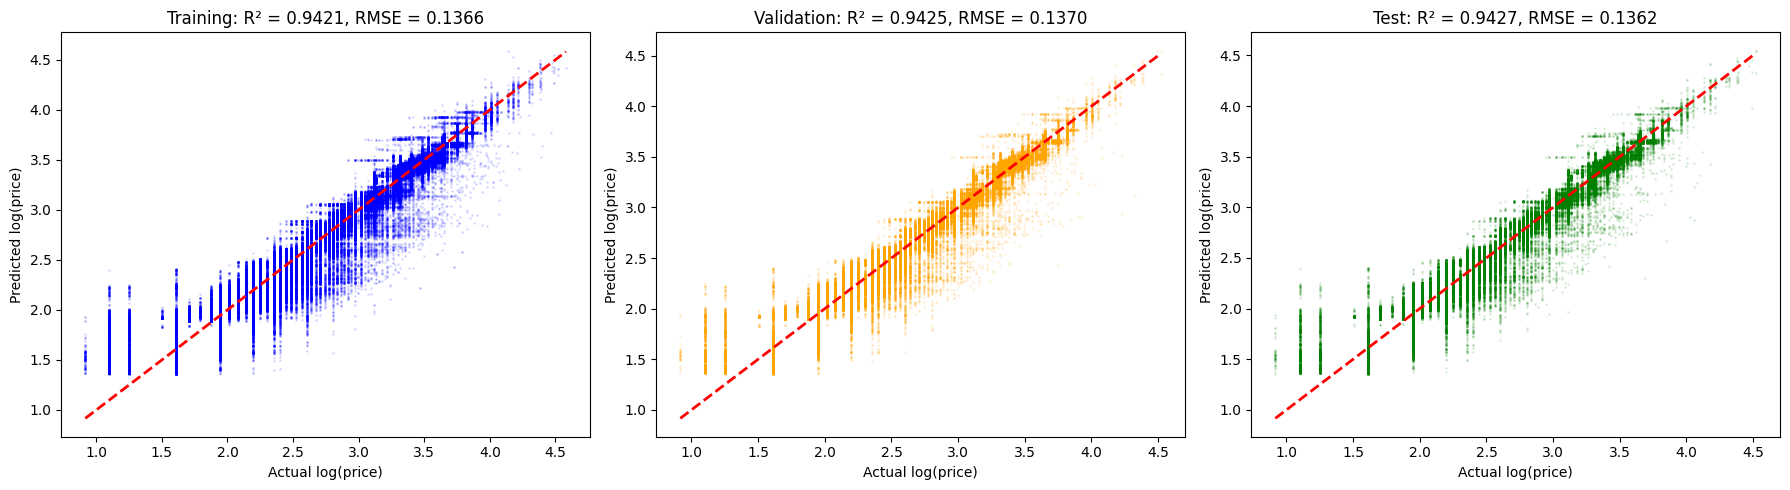

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


# Training (BLUE)
axes[0].scatter(y_train, y_train_pred_reduced, alpha=0.1, s=1, color='blue')
axes[0].plot([y_train.min(), y_train.max()],
             [y_train.min(), y_train.max()],
             'r--', linewidth=2)
axes[0].set_title(
    f"Training: R² = {train_metrics_reduced['R²']:.4f}, "
    f"RMSE = {train_metrics_reduced['RMSE']:.4f}"
)
axes[0].set_xlabel('Actual log(price)')
axes[0].set_ylabel('Predicted log(price)')


# Validation (orange)
axes[1].scatter(y_val, y_val_pred_reduced, alpha=0.1, s=1, color='orange')
axes[1].plot([y_val.min(), y_val.max()],
             [y_val.min(), y_val.max()],
             'r--', linewidth=2)
axes[1].set_title(
    f"Validation: R² = {val_metrics_reduced['R²']:.4f}, "
    f"RMSE = {val_metrics_reduced['RMSE']:.4f}"
)
axes[1].set_xlabel('Actual log(price)')
axes[1].set_ylabel('Predicted log(price)')


# Test (GREEN)
axes[2].scatter(y_test, y_test_pred_reduced, alpha=0.1, s=1, color='green')
axes[2].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
axes[2].set_title(
    f"Test: R² = {test_metrics_reduced['R²']:.4f}, "
    f"RMSE = {test_metrics_reduced['RMSE']:.4f}"
)
axes[2].set_xlabel('Actual log(price)')
axes[2].set_ylabel('Predicted log(price)')

plt.tight_layout()
plt.show()

**Insights:**

The multiple linear regression model demonstrates excellent predictive performance after incorporating the full set of engineered features, including numerical variables, cyclical time encodings, target-encoded locations, and one-hot encoded service and temporal categories. The fitted model contains 33 coefficients with an intercept of 2.0511, indicating a rich multivariate structure. Across all three data splits, the model achieves consistently high explanatory power, with R² = 0.9421 (training), 0.9425 (validation), and 0.9427 (test). Corresponding RMSE values remain tightly clustered around 0.137, reflecting low average prediction error in log-price units. The near-identical performance across training, validation, and test sets provides strong evidence that the model generalizes well and does not suffer from overfitting.

The actual-versus-predicted scatterplots further confirm the high quality of fit. In all three panels, predicted values align closely with the 45-degree reference line, indicating accurate recovery of both low- and high-priced rides. Compared to the baseline model (which achieved R² ≈ 0.11), the MLR model represents a dramatic improvement in explanatory power, capturing the combined effects of distance, time, weather, location, and service characteristics. The tight spread of points around the diagonal also suggests that the linear specification, when paired with appropriate feature engineering, is sufficient to model the dominant pricing structure in the data.

<a id="mlr-importance"></a>
## MLR Feature Importance

In [44]:
coef_df = pd.DataFrame({
    'Feature': kept_features,
    'Coefficient': mlr_lasso.coef_,
    'Abs_Coefficient': np.abs(mlr_lasso.coef_)
})

coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

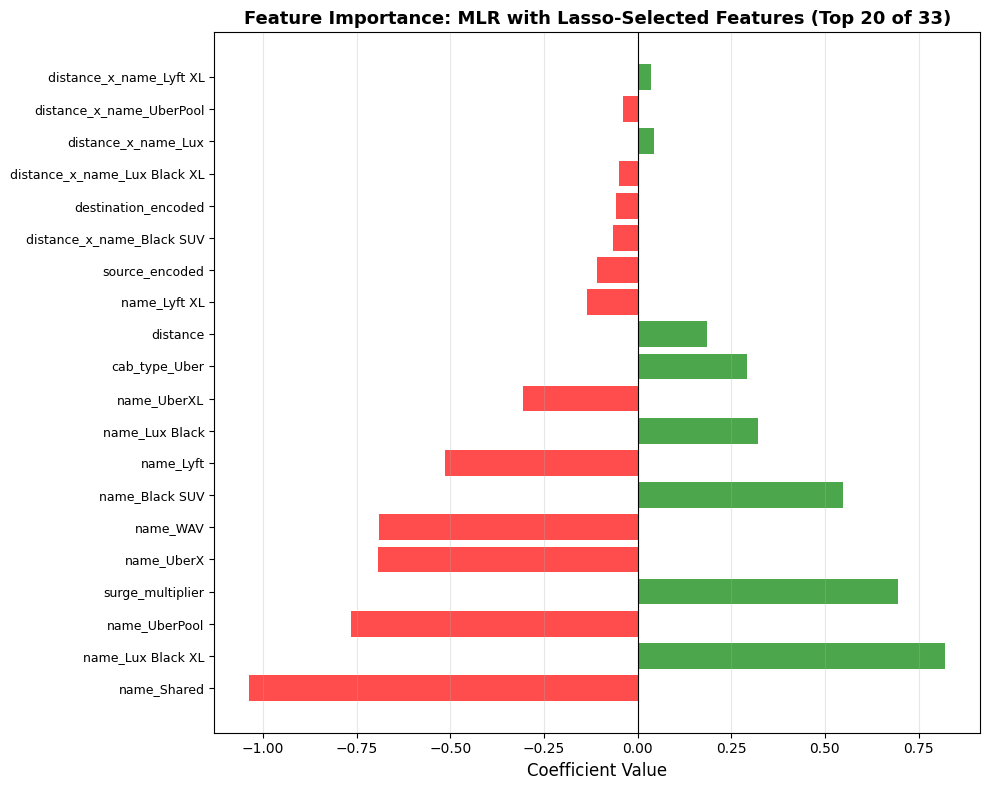

In [45]:
top_20_coefs = coef_df.head(20)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green' if x > 0 else 'red' for x in top_20_coefs['Coefficient']]
y_pos = range(len(top_20_coefs))

ax.barh(y_pos, top_20_coefs['Coefficient'], color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20_coefs['Feature'], fontsize=9)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title(f'Feature Importance: MLR with Lasso-Selected Features (Top 20 of {len(kept_features)})', 
             fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

**Insights:**

The feature importance patterns in the standard MLR and the polynomial-enhanced MLR are nearly identical, indicating that introducing nonlinear distance terms does not materially change the underlying pricing structure captured by the model. In both specifications, the strongest positive contributors remain `surge_multiplier` and premium service indicators such as `name_Lux Black XL`, `name_Black SUV`, and `name_Lux Black`, while lower-cost services including `name_Shared`, `name_UberPool`, `name_UberX`, and `name_WAV` consistently exhibit large negative coefficients. The linear `distance` term also retains a meaningful positive effect in both models.

Notably, the higher-order distance terms introduced in the polynomial model (`distance_sq` and `distance_cu`) do not rank among the most influential predictors, which explains why the polynomial-enhanced MLR achieves nearly the same predictive performance as the standard MLR. This confirms that, once service tier, surge dynamics, and location effects are accounted for, the relationship between `distance` and `log(price)` is largely linear in practice. The polynomial extension therefore adds modeling flexibility but does not alter the core economic drivers of ride pricing.


<a id="dt"></a>
# Decision Tree Regression

While multiple linear regression provides interpretable coefficients and strong predictive performance, decision trees are able to capture non-linear relationships and higher-order interactions automatically, without requiring them to be explicitly specified in the feature set. We therefore train a decision tree regression model using cross-validation to tune hyperparameters and to control overfitting.

To ensure a fair and consistent model comparison, we use the same data split as the MLR model:
- The same target variables: `y_train`, `y_val`, and `y_test`
- The same base feature matrices: `X_train_combined`, `X_val_combined`, and `X_test_combined`  
- Interaction terms are excluded because decision trees natively learn interaction effects through recursive partitioning
- The same random seed `random_state = 42` is used to ensure full reproducibility

This setup allows performance differences between MLR and the decision tree model to be attributed directly to model structure rather than differences in data preparation.

In [46]:
# define hyperparameter grid for cross-validation
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

dt_base = DecisionTreeRegressor(random_state=42)

print("Performing 5-fold cross-validation to find optimal hyperparameters...")
print("This may take a few minutes...\n")

grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# keep full feature set- excluding interaction terms from MLR
grid_search.fit(X_train_combined, y_train)

print("\nBest hyperparameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation RMSE: {-grid_search.best_score_:.4f}")

Performing 5-fold cross-validation to find optimal hyperparameters...
This may take a few minutes...

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best hyperparameters found:
  max_depth: 15
  max_features: None
  min_samples_leaf: 8
  min_samples_split: 20

Best cross-validation RMSE: 0.1309


In [47]:
# train final model with best hyperparameters
dt_model = grid_search.best_estimator_

# predictions 
y_train_pred_dt = dt_model.predict(X_train_combined)
y_val_pred_dt   = dt_model.predict(X_val_combined)
y_test_pred_dt  = dt_model.predict(X_test_combined)

<a id="dt-results"></a>
## Decision Tree Results

In [48]:
# evaluate performance
train_metrics_dt = calc_metrics(y_train, y_train_pred_dt, "Training")
val_metrics_dt   = calc_metrics(y_val, y_val_pred_dt, "Validation")
test_metrics_dt  = calc_metrics(y_test, y_test_pred_dt, "Test")

Training:
  R²:   0.9557
  RMSE: 0.1195
Validation:
  R²:   0.9476
  RMSE: 0.1308
Test:
  R²:   0.9483
  RMSE: 0.1293


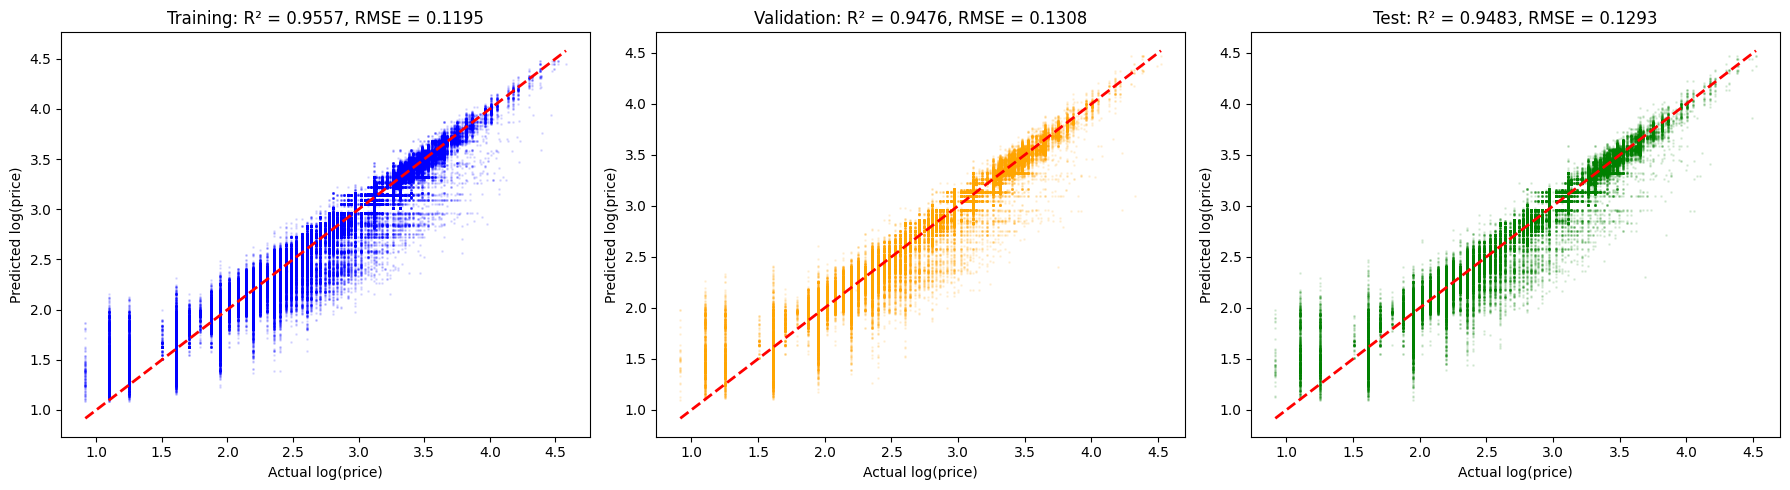

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training (BLUE)
axes[0].scatter(y_train, y_train_pred_dt, alpha=0.1, s=1, color='blue')
axes[0].plot([y_train.min(), y_train.max()],
             [y_train.min(), y_train.max()],
             'r--', linewidth=2)
axes[0].set_title(
    f"Training: R² = {train_metrics_dt['R²']:.4f}, "
    f"RMSE = {train_metrics_dt['RMSE']:.4f}"
)
axes[0].set_xlabel('Actual log(price)')
axes[0].set_ylabel('Predicted log(price)')


# Validation (orange)
axes[1].scatter(y_val, y_val_pred_dt, alpha=0.1, s=1, color='orange')
axes[1].plot([y_val.min(), y_val.max()],
             [y_val.min(), y_val.max()],
             'r--', linewidth=2)
axes[1].set_title(
    f"Validation: R² = {val_metrics_dt['R²']:.4f}, "
    f"RMSE = {val_metrics_dt['RMSE']:.4f}"
)
axes[1].set_xlabel('Actual log(price)')
axes[1].set_ylabel('Predicted log(price)')


# Test (GREEN)
axes[2].scatter(y_test, y_test_pred_dt, alpha=0.1, s=1, color='green')
axes[2].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
axes[2].set_title(
    f"Test: R² = {test_metrics_dt['R²']:.4f}, "
    f"RMSE = {test_metrics_dt['RMSE']:.4f}"
)
axes[2].set_xlabel('Actual log(price)')
axes[2].set_ylabel('Predicted log(price)')

plt.tight_layout()
plt.show()

**Insights:**

The decision tree regression model achieves strong predictive performance after 5-fold cross-validation–based hyperparameter tuning. The optimal configuration selects a tree with `max_depth = 15`, `min_samples_split = 20`, and `min_samples_leaf = 8`, balancing model flexibility with regularization to prevent overfitting. Under this setting, the model attains an excellent training R² of 0.9557 with RMSE = 0.1195, indicating a very close fit to the training data. Importantly, performance remains consistently high on unseen data, with validation R² = 0.9476 (RMSE = 0.1308) and test R² = 0.9483 (RMSE = 0.1293). The close alignment between training, validation, and test performance confirms that the tree generalizes well and is not memorizing noise, validating the effectiveness of the cross-validation tuning strategy.

The actual-versus-predicted scatterplots further demonstrate the decision tree’s strong predictive accuracy. Across all three splits, predicted values closely track the 45-degree reference line, indicating accurate recovery of both low- and high-priced rides.

<a id="dt-importance"></a>
## Decision Tree Feature Importance

Decision trees provide feature importance measures based on the **mean decrease in Gini impurity**. Each feature's importance is calculated as the total reduction in node impurity (weighted by the probability of reaching that node) when that feature is used for splitting across all nodes in the tree. This directly reflects how much each feature contributes to reducing variance in the predictions.

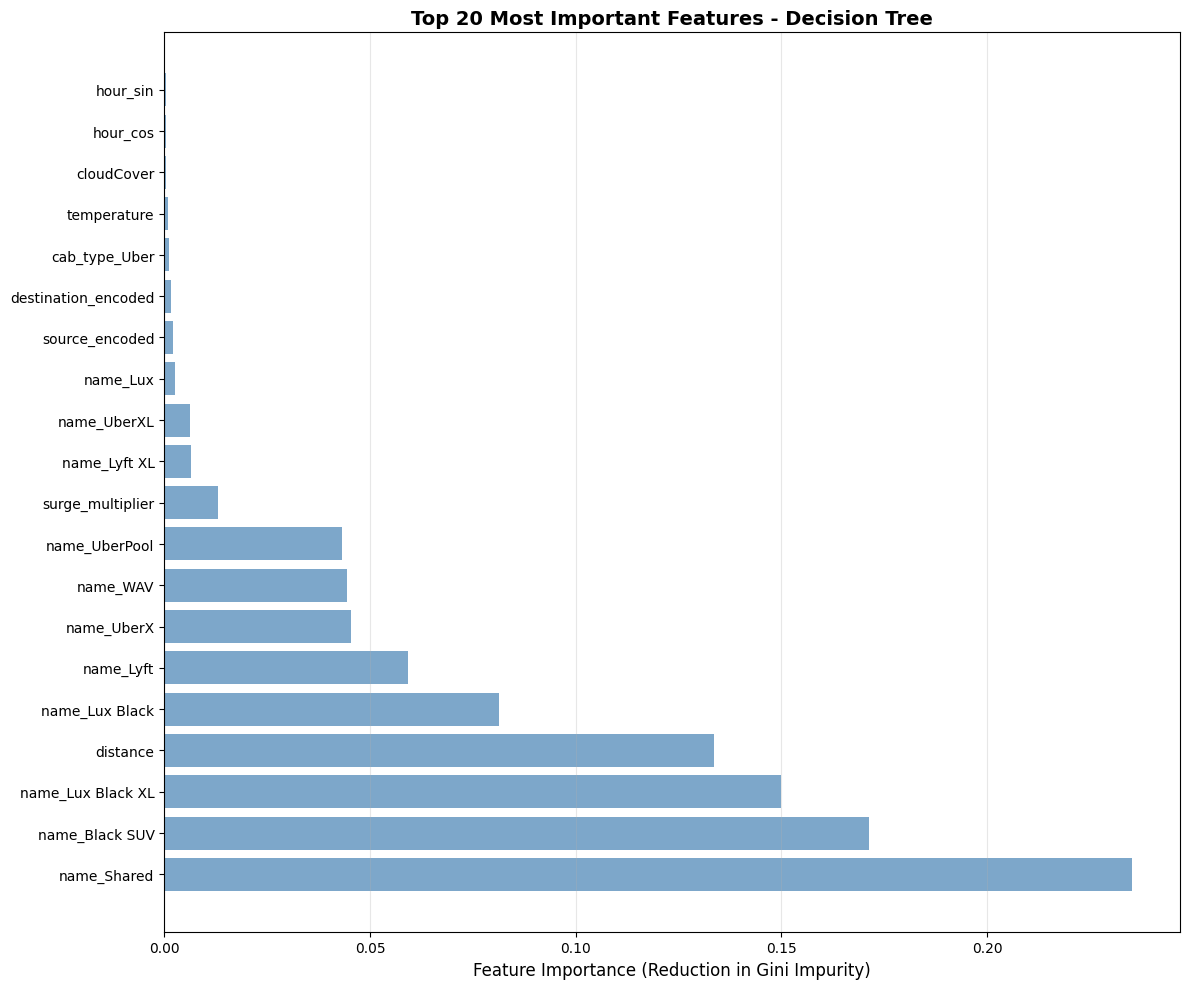


Top 20 Feature Importances:
 1. name_Shared                              0.2351
 2. name_Black SUV                           0.1714
 3. name_Lux Black XL                        0.1499
 4. distance                                 0.1336
 5. name_Lux Black                           0.0813
 6. name_Lyft                                0.0592
 7. name_UberX                               0.0453
 8. name_WAV                                 0.0444
 9. name_UberPool                            0.0432
10. surge_multiplier                         0.0131
11. name_Lyft XL                             0.0066
12. name_UberXL                              0.0063
13. name_Lux                                 0.0025
14. source_encoded                           0.0022
15. destination_encoded                      0.0016
16. cab_type_Uber                            0.0012
17. temperature                              0.0008
18. cloudCover                               0.0006
19. hour_cos                       

In [50]:
# extract feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train_combined.columns,
    'Importance': dt_model.feature_importances_
})

# get top 20 features
top_20_dt_features = feature_importance_df.nlargest(20, 'Importance')

# plot feature importances
fig, ax = plt.subplots(figsize=(12, 10))
colors_dt = ['steelblue' for _ in range(len(top_20_dt_features))]
bars = ax.barh(range(len(top_20_dt_features)), top_20_dt_features['Importance'], color=colors_dt, alpha=0.7)
ax.set_yticks(range(len(top_20_dt_features)))
ax.set_yticklabels(top_20_dt_features['Feature'], fontsize=10)
ax.set_xlabel('Feature Importance (Reduction in Gini Impurity)', fontsize=12)
ax.set_title('Top 20 Most Important Features - Decision Tree', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 20 Feature Importances:")
for i, (idx, row) in enumerate(top_20_dt_features.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:40s} {row['Importance']:.4f}")

**Insights**

The decision tree feature-importance results reveal a pricing structure dominated by service type and trip length rather than weather or time variables. The most influential predictor is `name_Shared` (importance = 0.2351), followed by `name_Black SUV` (0.1714) and `name_Lux Black XL` (0.1499), indicating that the service category alone drives a substantial portion of fare variation through nonlinear threshold splits. `distance` ranks as the fourth most important feature (0.1336), confirming that trip length remains a fundamental driver of pricing even in a highly flexible nonlinear model. Mid-tier services such as `name_Lux Black`, `name_Lyft`, `name_UberX`, `name_WAV`, and `name_UberPool` also exhibit moderate importance, reflecting distinct fare regimes learned by the tree. In contrast, spatial effects (`source_encoded`, `destination_encoded`), platform (`cab_type_Uber`), and environmental variables (`temperature`, `cloudCover`, `hour_sin`, `hour_cos`) contribute minimally, suggesting that once service tier, surge behavior (`surge_multiplier`), and distance are accounted for, time and weather play only a secondary role in tree-based pricing decisions. Overall, the dominance of categorical service splits highlights the decision tree’s ability to exploit discrete pricing rules and nonlinear service-level thresholds that are not explicitly encoded in linear models.

<a id="poly"></a>
# Polynomial Regressions

<a id="simple-poly"></a>
## Simple Polynomial Regression (Distance-Only Model)

To examine whether the relationship between trip `distance` and `log(price)` exhibits meaningful nonlinear structure beyond the baseline linear assumption, we extend the baseline model to a polynomial regression framework. This approach allows the marginal effect of distance on price to vary with trip length by introducing higher-order powers of `distance`, while still retaining a single-predictor structure for interpretability and fair comparison with the baseline model.

Using only `distance` as the predictor, we construct polynomial feature expansions of degrees 1, 2, and 3 via `PolynomialFeatures(include_bias = False)`. Each polynomial model is fit on the training set and evaluated on validation and test sets using the same performance metrics (`R²` and `RMSE`) as the multiple linear regression and decision tree models. By holding all other features constant and varying only the polynomial degree, this experiment isolates the contribution of nonlinear distance effects to ride pricing performance.

In [51]:
# extract distance-only features
X_train_dist = X_train[['distance']].copy()
X_val_dist   = X_val[['distance']].copy()
X_test_dist  = X_test[['distance']].copy()

def evaluate_poly_model(degree):
    """
    Build and evaluate a polynomial regression model using only 'distance'.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    # transform inputs
    X_train_poly = poly.fit_transform(X_train_dist)
    X_val_poly   = poly.transform(X_val_dist)
    X_test_poly  = poly.transform(X_test_dist)

    # fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # predictions
    y_train_pred = model.predict(X_train_poly)
    y_val_pred   = model.predict(X_val_poly)
    y_test_pred  = model.predict(X_test_poly)

    print(f"\nPolynomial Degree {degree}")


    train_metrics = calc_metrics(y_train, y_train_pred, "Training")
    val_metrics   = calc_metrics(y_val, y_val_pred, "Validation")
    test_metrics  = calc_metrics(y_test, y_test_pred, "Test")

    return {
        'degree': degree,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'model': model,
        'poly': poly
    }

<a id="simple-poly-results"></a>
## Simple Polynomial Regression Results

In [52]:
# evaluate polynomial degrees
results_poly = []
for d in [1, 2, 3]:
    results_poly.append(evaluate_poly_model(d))


Polynomial Degree 1
Training:
  R²:   0.1135
  RMSE: 0.5347
Validation:
  R²:   0.1169
  RMSE: 0.5368
Test:
  R²:   0.1149
  RMSE: 0.5352

Polynomial Degree 2
Training:
  R²:   0.1160
  RMSE: 0.5340
Validation:
  R²:   0.1194
  RMSE: 0.5361
Test:
  R²:   0.1175
  RMSE: 0.5344

Polynomial Degree 3
Training:
  R²:   0.1161
  RMSE: 0.5339
Validation:
  R²:   0.1196
  RMSE: 0.5360
Test:
  R²:   0.1176
  RMSE: 0.5344


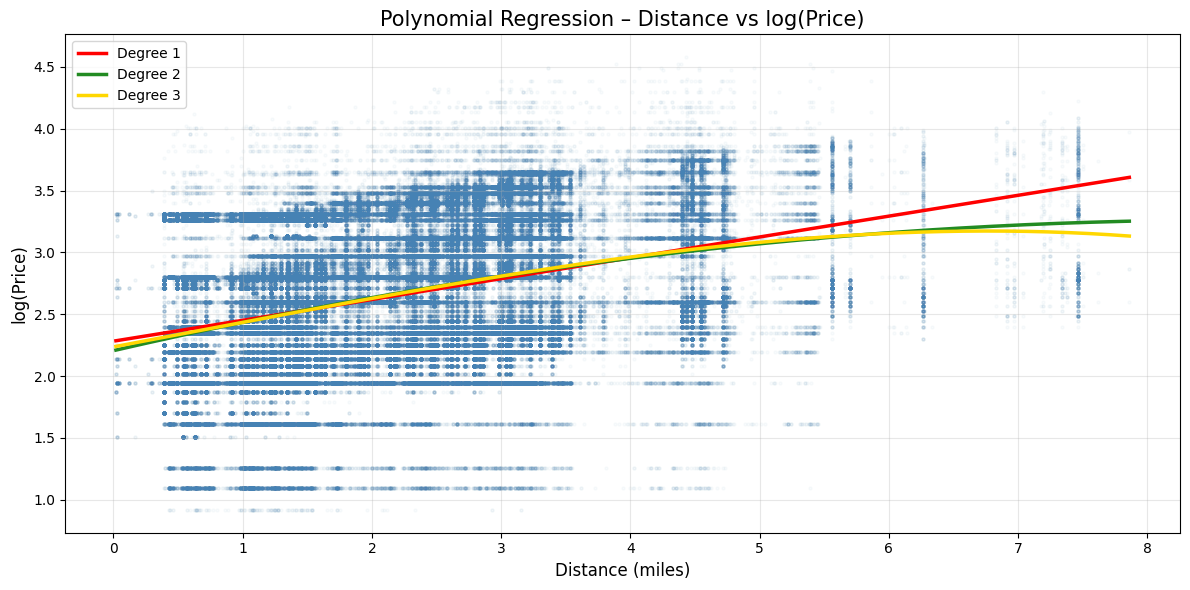

In [53]:
# grid for smooth curve
dist_plot = np.linspace(
    X_train['distance'].min(),
    X_train['distance'].max(),
    500
).reshape(-1, 1)

plt.figure(figsize=(12, 6))

colors = {1: 'red', 2: 'forestgreen', 3: 'gold'}

for degree in [1, 2, 3]:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    model = LinearRegression()
    
    # fit on training distance only
    X_train_poly = poly.fit_transform(X_train_dist)
    model.fit(X_train_poly, y_train)

    # transform plotting grid using SAME transformer
    dist_plot_poly = poly.transform(dist_plot)

    # plot fitted curve
    plt.plot(
        dist_plot,
        model.predict(dist_plot_poly),
        linewidth=2.5,
        color=colors[degree],
        label=f"Degree {degree}"
    )

# scatter training points
plt.scatter(
    X_train['distance'],
    y_train,
    alpha=0.03,
    s=5,
    color='steelblue'
)

plt.xlabel("Distance (miles)", fontsize=12)
plt.ylabel("log(Price)", fontsize=12)
plt.title("Polynomial Regression – Distance vs log(Price)", fontsize=15)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Insights:**

Polynomial regression using only `distance` provides negligible improvement over the baseline linear model. Across degrees 1, 2, and 3, the validation and test performance remains nearly identical, with `R²` staying around 0.12 and `RMSE` around 0.535. This confirms that introducing nonlinear distance terms does not materially improve predictive accuracy when distance is used as the sole predictor.

The fitted curves show only minor curvature at longer distances, and the higher-degree models (2 and 3) closely overlap with the linear fit across most of the distance range. This indicates that the relationship between `distance` and `log(price)` is largely linear in practice, and that the dominant drivers of ride pricing lie in additional variables such as service type, surge behavior, temporal effects, and location rather than nonlinear distance effects alone.


<a id="full-poly"></a>
## Full Polynomial Regression with Lasso-Selected Features

The results from our multiple linear regression and Lasso feature selection indicate that not all predictors contribute meaningfully to ride-share pricing. Lasso identifies a compact subset of variables, including numerical features, target-encoded neighborhood effects, selected one-hot encoded service attributes, and key interaction terms—that jointly explain nearly all variation in log(price).

Building on this reduced and more interpretable feature space, we extend the model by introducing nonlinear terms only for distance. Distance is the one continuous predictor that displays clear curvature in its relationship with log(price), as shown in the EDA and distance-only polynomial diagnostics. In contrast, other numerical variables (surge multiplier, temperature, precipitation, temporal indicators) show weak or linear patterns, and Lasso further confirms their limited nonlinear contribution.

Therefore, our polynomial model:

- Retains all predictors selected by Lasso (`kept_features`)
- Adds distance² and distance³ to allow mild curvature in the distance–price relationship
- Leaves all other predictors in linear form, preserving interpretability and avoiding unnecessary dimensional expansion `temperature`

In [54]:
X_train_poly = X_train_reduced.copy()
X_val_poly   = X_val_reduced.copy()
X_test_poly  = X_test_reduced.copy()

# add polynomial distance terms
for df_poly in [X_train_poly, X_val_poly, X_test_poly]:
    df_poly['distance_sq'] = df_poly['distance'] ** 2
    df_poly['distance_cu'] = df_poly['distance'] ** 3

print("Polynomial feature matrices created:")
print(f"  Train: {X_train_poly.shape}")
print(f"  Val:   {X_val_poly.shape}")
print(f"  Test:  {X_test_poly.shape}")


# Fit Polynomial-Enhanced MLR

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# predictions
y_train_pred_poly = poly_model.predict(X_train_poly)
y_val_pred_poly   = poly_model.predict(X_val_poly)
y_test_pred_poly  = poly_model.predict(X_test_poly)

Polynomial feature matrices created:
  Train: (382785, 35)
  Val:   (127595, 35)
  Test:  (127596, 35)


<a id="full-poly-results"></a>
## Full Polynomial Regression Results

In [55]:
#Metrics
print("\n=== Polynomial Regression (Lasso-Selected Features) ===")

train_metrics_poly = calc_metrics(y_train, y_train_pred_poly, "Training")
val_metrics_poly   = calc_metrics(y_val,   y_val_pred_poly,   "Validation")
test_metrics_poly  = calc_metrics(y_test,  y_test_pred_poly,  "Test")


=== Polynomial Regression (Lasso-Selected Features) ===
Training:
  R²:   0.9439
  RMSE: 0.1345
Validation:
  R²:   0.9443
  RMSE: 0.1348
Test:
  R²:   0.9445
  RMSE: 0.1340


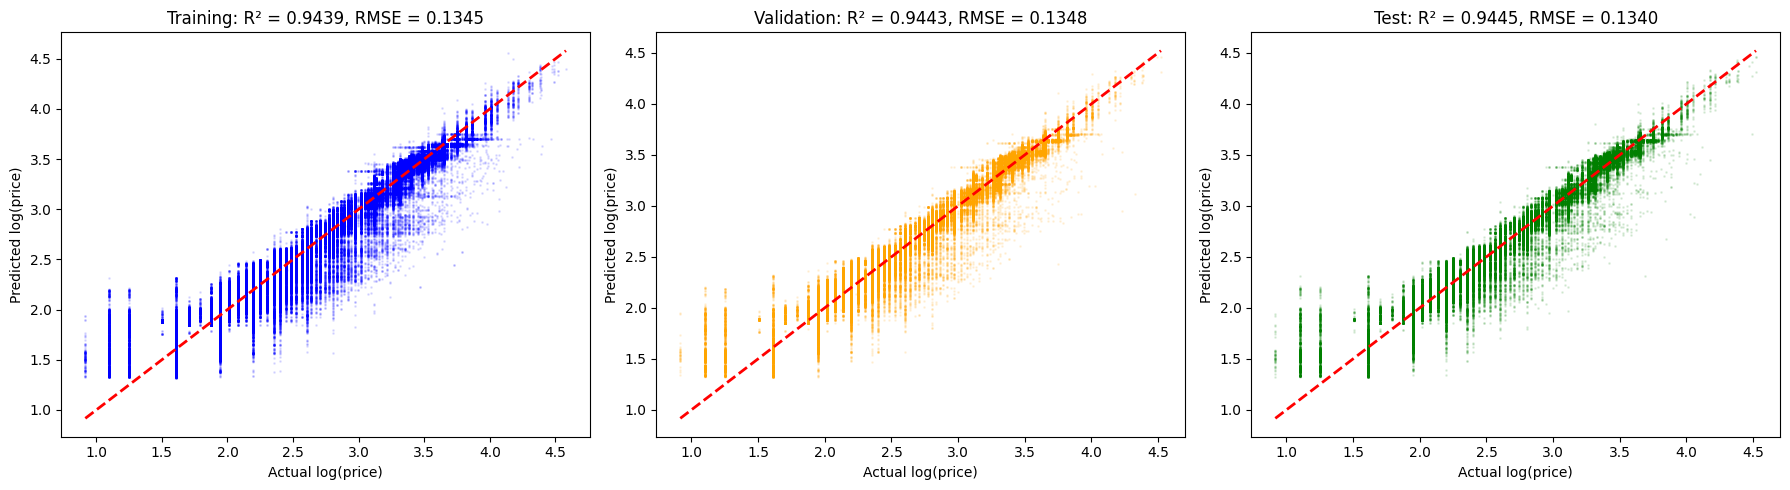

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


# Training (BLUE)
axes[0].scatter(y_train, y_train_pred_poly, alpha=0.1, s=1, color='blue')
axes[0].plot([y_train.min(), y_train.max()],
             [y_train.min(), y_train.max()],
             'r--', linewidth=2)
axes[0].set_title(
    f"Training: R² = {train_metrics_poly['R²']:.4f}, "
    f"RMSE = {train_metrics_poly['RMSE']:.4f}"
)
axes[0].set_xlabel('Actual log(price)')
axes[0].set_ylabel('Predicted log(price)')


# Validation (orange)
axes[1].scatter(y_val, y_val_pred_poly, alpha=0.1, s=1, color='orange')
axes[1].plot([y_val.min(), y_val.max()],
             [y_val.min(), y_val.max()],
             'r--', linewidth=2)
axes[1].set_title(
    f"Validation: R² = {val_metrics_poly['R²']:.4f}, "
    f"RMSE = {val_metrics_poly['RMSE']:.4f}"
)
axes[1].set_xlabel('Actual log(price)')
axes[1].set_ylabel('Predicted log(price)')


# Test (GREEN)
axes[2].scatter(y_test, y_test_pred_poly, alpha=0.1, s=1, color='green')
axes[2].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
axes[2].set_title(
    f"Test: R² = {test_metrics_poly['R²']:.4f}, "
    f"RMSE = {test_metrics_poly['RMSE']:.4f}"
)
axes[2].set_xlabel('Actual log(price)')
axes[2].set_ylabel('Predicted log(price)')

plt.tight_layout()
plt.show()

**Insights:**

Adding polynomial terms `distance_sq` and `distance_cu` to the LASSO-selected MLR model yields only a marginal performance change relative to the original MLR. The model achieves highly consistent results across all splits, with `R² ≈ 0.944` and `RMSE ≈ 0.134`, indicating strong generalization but no meaningful improvement over the linear specification. This suggests that the nonlinear distance effects captured by higher-order powers are largely redundant once service type, surge behavior, time, and location features are already included.

The actual-versus-predicted plots confirm this conclusion, as predictions remain tightly aligned with the 45-degree reference line and visually indistinguishable from the standard MLR results. Overall, these findings indicate that the dominant nonlinear pricing behavior is already captured by other engineered features, and additional polynomial distance terms do not provide significant incremental predictive value.


<a id="full-poly-importance"></a>
## Full Polynomial Regression Feature Importance

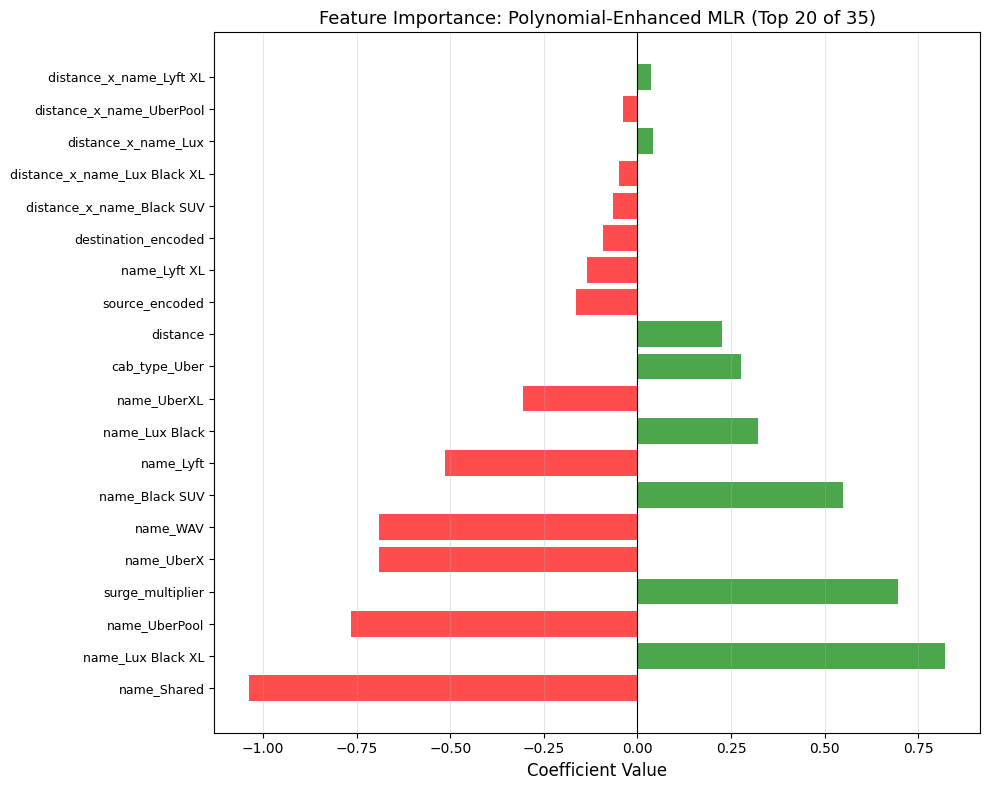

In [61]:
# FEATURE IMPORTANCE: FULL POLYNOMIAL MODEL

coef_poly_df = pd.DataFrame({
    'Feature': X_train_poly.columns,
    'Coefficient': poly_model.coef_,
    'Abs_Coefficient': np.abs(poly_model.coef_)
})

# sort by absolute magnitude
coef_poly_df = coef_poly_df.sort_values('Abs_Coefficient', ascending=False)

# keep top 20
top_20_poly_coefs = coef_poly_df.head(20)



# PLOT COEFFICIENTS
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green' if x > 0 else 'red' for x in top_20_poly_coefs['Coefficient']]
y_pos = range(len(top_20_poly_coefs))

ax.barh(y_pos, top_20_poly_coefs['Coefficient'], color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20_poly_coefs['Feature'], fontsize=9)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title(
    f'Feature Importance: Polynomial-Enhanced MLR (Top 20 of {X_train_poly.shape[1]})', 
    fontsize=13
)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

**Insights:**

The dominant drivers of predicted `log(price)` in the polynomial-enhanced model remain highly consistent with the standard MLR. The largest positive effects are associated with `name_Lux Black XL`, `surge_multiplier`, and `name_Black SUV`, confirming that premium service categories and surge pricing continue to exert the strongest upward influence on fares. In contrast, economy and shared ride options such as `name_Shared`, `name_UberPool`, and `name_WAV` exhibit the most negative coefficients, reflecting their systematically lower pricing structure.

Despite explicitly adding nonlinear terms, the polynomial contribution of `distance` remains modest relative to service-type and surge variables. The base term `distance` retains a moderate positive effect, while higher-order distance interactions and polynomial components appear only among smaller-magnitude coefficients. This confirms that once rich categorical and dynamic pricing factors are included, nonlinear distance effects contribute little incremental explanatory power beyond what is already captured by the linear structure.

<a id="model-comparison"></a>
# Model Comparison

In [57]:
# CREATE FULL COMPARISON TABLE

comparison_df = pd.DataFrame({
    'Model': [
        'Baseline (Distance Only)',
        'Multiple Linear Regression (Lasso-Reduced)',
        'Decision Tree (Full Features)',
        'Polynomial-Enhanced MLR (Full Poly)'
    ],
    'Train R²': [
        train_metrics_baseline['R²'],
        train_metrics_reduced['R²'],
        train_metrics_dt['R²'],
        train_metrics_poly['R²']
    ],
    'Train RMSE': [
        train_metrics_baseline['RMSE'],
        train_metrics_reduced['RMSE'],
        train_metrics_dt['RMSE'],
        train_metrics_poly['RMSE']
    ],
    'Validation R²': [
        val_metrics_baseline['R²'],
        val_metrics_reduced['R²'],
        val_metrics_dt['R²'],
        val_metrics_poly['R²']
    ],
    'Validation RMSE': [
        val_metrics_baseline['RMSE'],
        val_metrics_reduced['RMSE'],
        val_metrics_dt['RMSE'],
        val_metrics_poly['RMSE']
    ],
    'Test R²': [
        test_metrics_baseline['R²'],
        test_metrics_reduced['R²'],
        test_metrics_dt['R²'],
        test_metrics_poly['R²']
    ],
    'Test RMSE': [
        test_metrics_baseline['RMSE'],
        test_metrics_reduced['RMSE'],
        test_metrics_dt['RMSE'],
        test_metrics_poly['RMSE']
    ]
})

print("\nModel Performance Comparison:")
print("="*116)
print(comparison_df.to_string(index=False))
print("="*116)


Model Performance Comparison:
                                     Model  Train R²  Train RMSE  Validation R²  Validation RMSE  Test R²  Test RMSE
                  Baseline (Distance Only)  0.113487    0.534706       0.116932         0.536810 0.114861   0.535216
Multiple Linear Regression (Lasso-Reduced)  0.942103    0.136647       0.942525         0.136950 0.942717   0.136156
             Decision Tree (Full Features)  0.955698    0.119533       0.947606         0.130756 0.948314   0.129333
       Polynomial-Enhanced MLR (Full Poly)  0.943936    0.134466       0.944306         0.134812 0.944541   0.133971


In [58]:
baseline_gap = train_metrics_baseline['R²'] - val_metrics_baseline['R²']
mlr_gap      = train_metrics_reduced['R²']  - val_metrics_reduced['R²']
dt_gap       = train_metrics_dt['R²']       - val_metrics_dt['R²']
poly_gap     = train_metrics_poly['R²']     - val_metrics_poly['R²']

print("\nOverfitting Analysis (Train R² - Validation R²):")
print(f"  Baseline:        {baseline_gap:.4f}")
print(f"  MLR:             {mlr_gap:.4f}")
print(f"  Decision Tree:  {dt_gap:.4f}")
print(f"  Full Polynomial:{poly_gap:.4f}")


Overfitting Analysis (Train R² - Validation R²):
  Baseline:        -0.0034
  MLR:             -0.0004
  Decision Tree:  0.0081
  Full Polynomial:-0.0004


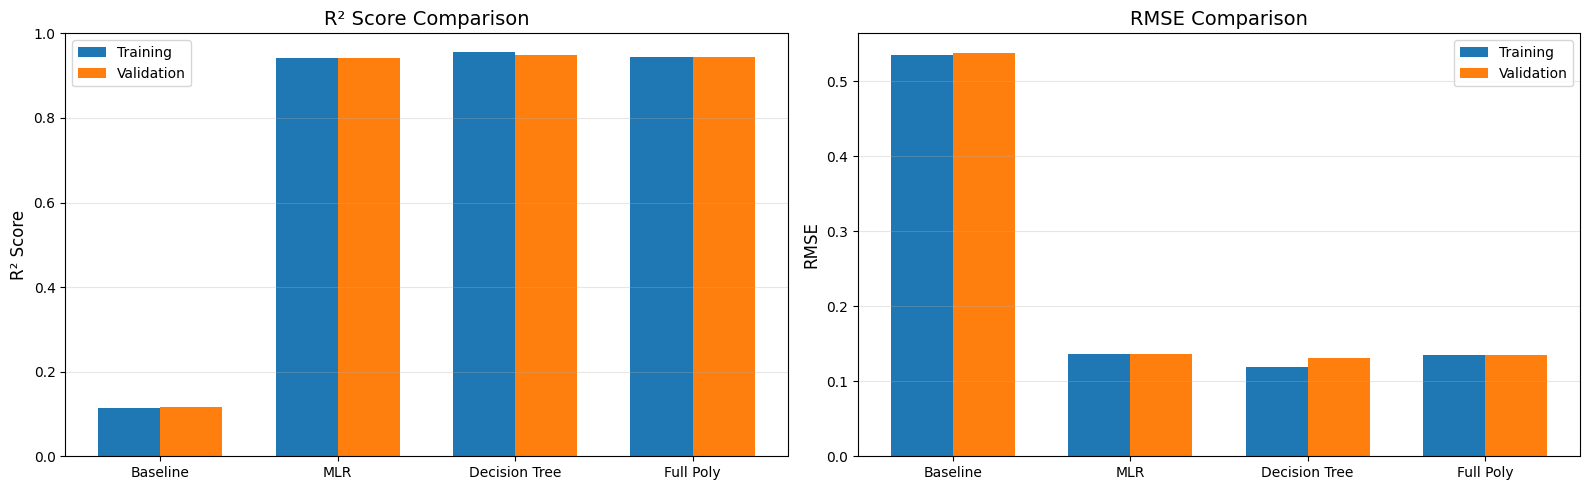

In [59]:
# =========================
# VISUAL COMPARISON PLOTS
# =========================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

models = ['Baseline', 'MLR', 'Decision Tree', 'Full Poly']
x = np.arange(len(models))
width = 0.35

# ---- R² Comparison ----
train_r2 = [
    train_metrics_baseline['R²'],
    train_metrics_reduced['R²'],
    train_metrics_dt['R²'],
    train_metrics_poly['R²']
]

val_r2 = [
    val_metrics_baseline['R²'],
    val_metrics_reduced['R²'],
    val_metrics_dt['R²'],
    val_metrics_poly['R²']
]

axes[0].bar(x - width/2, train_r2, width, label='Training')
axes[0].bar(x + width/2, val_r2, width, label='Validation')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.0, 1.0])

# ---- RMSE Comparison ----
train_rmse = [
    train_metrics_baseline['RMSE'],
    train_metrics_reduced['RMSE'],
    train_metrics_dt['RMSE'],
    train_metrics_poly['RMSE']
]

val_rmse = [
    val_metrics_baseline['RMSE'],
    val_metrics_reduced['RMSE'],
    val_metrics_dt['RMSE'],
    val_metrics_poly['RMSE']
]

axes[1].bar(x - width/2, train_rmse, width, label='Training')
axes[1].bar(x + width/2, val_rmse, width, label='Validation')
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('RMSE Comparison', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

**Insights:**


The baseline model using only `distance` performs very poorly (`Test R² ≈ 0.115`, `RMSE ≈ 0.535`), confirming that **distance alone explains only a small fraction of the variation in ride prices**. In contrast, all feature-rich models achieve dramatically stronger performance (`Test R² ≈ 0.943–0.948`, `RMSE ≈ 0.129–0.136`), demonstrating the critical importance of incorporating service type, surge behavior, temporal effects, and location information.

Among the advanced models, the **Decision Tree achieves the best overall test performance** (`Test R² = 0.9483`, `RMSE = 0.1293`), slightly outperforming both the LASSO-reduced MLR and the polynomial-enhanced MLR. The **full polynomial MLR does not improve upon the linear MLR**, indicating that once rich categorical, temporal, and spatial features are included, **additional nonlinear distance terms contribute little incremental value**. Overfitting gaps are near zero for all models, with the Decision Tree showing only a minimal gap (`0.0081`), confirming that **cross-validation effectively controlled model complexity and ensured strong generalization**.